In [4]:
# imports
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import glob
import os
import csv
import re
import more_itertools as mit

In [5]:
os.getcwd()

'/Users/hayleykisiel/Desktop/uva_capstone_F21_fhr_detection-master/common/ipynb_tests'

In [6]:
# extract all files in the annotation folder and write to a list
path = "../../data/annotations/csv/"

fileScanner = os.scandir(path)
AnnFiles = []
for file in fileScanner:
    if file.is_file():
        AnnFiles.append(file.name)

In [7]:
# show one name
AnnFiles[0:5]

['annotation_1178.csv',
 'annotation_1144.csv',
 'annotation_1150.csv',
 'annotation_1187.csv',
 'annotation_1193.csv']

In [5]:
# make sure path is correct
f'../../data/annotations/csv/{AnnFiles[314]}'

'../../data/annotations/csv/annotation_1072.csv'

In [45]:
# loop over each AnnFiles and transpose files as needed 
import time
start_time = time.time()

for i in range(len(AnnFiles)):
    
    try:
    
        df = pd.read_csv(f'../../data/annotations/csv/{AnnFiles[i]}', header=None)

        if len(df) == 5: 
            df = df.T
            df.to_csv(f'../../data/annotations/csv/{AnnFiles[i]}', header=False, index=False)

        else:
            continue
    except:
        
        print(i)
        
print("--- %s seconds ---" % (time.time() - start_time))

80
433
--- 452.5286691188812 seconds ---


In [8]:
def delete_keys(d):
        del_k = [k for k in d if len(d[k]) != 2]
        for k in del_k: del d[k] 

In [9]:
"""Accessing and interacting with Record files"""

class Record():
    """Class for interacting with record files"""

    def __init__(self, record_name: str) -> None:
        """Initialzes the record class"""
        self.record_name = record_name
        self.uc = {} 
        self.dec = {}
        self.acc = {}
        self.tc = {}
        self.bc = {}
        self.ann = {}
        self._signalDf = pd.read_csv(f'../../data/database/signals/{record_name}.csv', na_values=['0.0'])

        # Call to get annotations
        self.__getannotations(self.record_name)

        # call to static method to create uc_dict
  


    def __getannotations(self, record_name) -> None:
        """Gets the annotations from the annotation csv file
        and populates the appropriate annotation list"""

        
        with open(f'../../data/annotations/csv/annotation_{record_name}.csv', newline='',
        encoding='UTF-8') as csvfile:
            annreader = csv.reader(csvfile, delimiter=',')
            for i, row in enumerate(annreader):
                                
                joined_row = ''.join(row)
                ##### transpose joined_row if data is in a single row
                
                if 'UC' in joined_row:
                    for ann in re.findall(r'[\(\)]UC\d+', joined_row):
                        if ann[0] == '(':
                            self.uc[ann[1:]] = [i]  
                        if ann[0] == ')' and ann[1:] in self.uc.keys():
                            self.uc[ann[1:]].append(i)        
                if 'DEC' in joined_row:
                    for ann in re.findall(r'[\(\)]DEC\d+', joined_row):
                        if ann[0] == '(':
                            self.dec[ann[1:]] = [i]  
                        if ann[0] == ')' and ann[1:] in self.dec.keys():
                            self.dec[ann[1:]].append(i)
                if 'ACC' in joined_row:
                    for ann in re.findall(r'[\(\)]ACC\d+', joined_row):
                        if ann[0] == '(':
                            self.acc[ann[1:]] = [i]  
                        if ann[0] == ')' and ann[1:] in self.acc.keys():
                            self.acc[ann[1:]].append(i)
                if 'TC' in joined_row:
                    for ann in re.findall(r'[\(\)]TC\d+', joined_row):
                        if ann[0] == '(':
                            self.tc[ann[1:]] = [i]  
                        if ann[0] == ')' and ann[1:] in self.tc.keys():
                            self.tc[ann[1:]].append(i)
                if 'BC' in joined_row:
                    for ann in re.findall(r'[\(\)]BC\d+', joined_row):
                        if ann[0] == '(':
                            self.bc[ann[1:]] = [i]  
                        if ann[0] == ')' and ann[1:] in self.bc.keys():
                            self.bc[ann[1:]].append(i)
                
        for d in [self.uc, self.dec, self.acc, self.tc, self.bc]: delete_keys(d)
            
        self.ann = dict(zip(["UC","DEC","ACC","TC","BC"],[self.uc, self.dec, self.acc, self.tc, self.bc]))

    def plotUC(self, ucNum: int):
            self.createPlot(ucNum)
            plt.show()        

    def createPlot(self, ucNum: int):
        """Plots the UC contraction and FHR specified by ucNum"""
        plotNum = 'UC'+str(ucNum)
        if plotNum in self.uc.keys():
            start, end = self.uc[plotNum]
            x = self._signalDf['seconds'][start:end].to_numpy()
            y_uc = self._signalDf['UC'][start:end].interpolate(method='linear').to_numpy()
            y_fhr = self._signalDf['FHR'][start:end].interpolate(method='linear').to_numpy()

#            y_uc = self._signalDf['UC'][start:end].to_numpy()
#            y_fhr = self._signalDf['FHR'][start:end].to_numpy()
            
            # FHR subplot
            fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
            axs[0].set_title(f'Record {self.record_name} {plotNum}')
            axs[0].plot(x, y_fhr, '#1f77b4')
            axs[0].set_xlim(start+2, end+2)
            axs[0].set_ylabel('FHR')
            axs[0].set_ylim(0, 220)
            # Uterine Contraction subplot
            axs[1].plot(x, y_uc, '#ff7f0e')
            axs[1].set_xlim(start+2, end+2)
            axs[1].set_ylim(0, 140)
            axs[1].set_ylabel('Uterine Contraction')
            fig.set_size_inches(8, 4)

    def _savePlot(self, ucStr):
#         """Plots the UC contraction and FHR specified by ucNum"""
#         plotNum = ucStr
#         if plotNum in self.uc.keys():
#             start, end = self.uc[plotNum]
#             x = self._signalDf['seconds'][start:end].to_numpy()
#             y_uc = self._signalDf['UC'][start:end].interpolate(method='linear').to_numpy()
#             y_fhr = self._signalDf['FHR'][start:end].interpolate(method='linear').to_numpy()
            
#             fig, ax = plt.subplots(nrows=1, ncols=1)
#             ax.set_title(f'Record {self.record_name} {plotNum}')
#             ax.plot(x, y_uc, '#1f77b4', x, y_fhr, '#ff7f0e')
#             ax.set_xlim(start+2, end+2)
#             ax.set_ylim(0, 220)
#             fig.set_size_inches(18, 8)

            self.createPlot(int(ucStr[2:]))

            fig = plt.gcf()
            fig.set_size_inches(18, 8)
            fig.savefig(f"../../data/images/record_{self.record_name}_{ucStr}.png", bbox_inches='tight')
            plt.close(fig)

    def saveImages(self):
        """Saves the images in ../../data/images/{record_name}"""
        missingdata = self.findMissing()
        
        for key in self.uc:
            if int(key[2:]) not in missingdata:
                self._savePlot(key)
          
        print(f"Images for Record {self.record_name} have been saved.")
    
                
    def clearImages(self):
        """Deletes the images in ../../data/images/{record_name}"""
        imgs = glob.glob(f'../../data/images/record_{self.record_name}/*.png', recursive=True)

        for img in imgs:
            try:
                os.remove(img)
            except OSError as e:
                print("Error: %s : %s" % (img, e.strerror))
                
    def findMissing(self):
        NA_list = []

        # gets all null index values within contraction times
        for i in range(len(self.ann['UC'])):

            annotation_start = list(self.ann['UC'].items())[i][1][0]
            annotation_end = list(self.ann['UC'].items())[i][1][1]

            rec_df = self._signalDf['FHR'][annotation_start:annotation_end]
            NA_list.append(list(rec_df[rec_df.isna()].index))

        # finds consecutive index of null values
        null_list = []
        for i in range(len(NA_list)): 

            temp_list = NA_list[i]
            null_groups = [list(group) for group in mit.consecutive_groups(temp_list)] #gets consecutive numbers
            null_list.append(null_groups)

        # searches for over 15 seconds of consecutive loss
        uc_list = []
        for i1 in range((len(null_list))):
            for i2 in range(len(null_list[i1])):
                if len(null_list[i1][i2]) > 60:
                    new_val = i1+1 # contraction with missing data
                    uc_list.append(new_val)

        return uc_list

In [10]:
### testing - HK

In [ ]:
record_numbers = list(map(lambda i: i[11:-4], AnnFiles))

error_list = []
for i in record_numbers:
    try: 
        rec = Record(i)
        rec.saveImages()

        del rec
    except:
        error_list.append(i)

Images for Record 1178 have been saved.
Images for Record 1144 have been saved.
Images for Record 1150 have been saved.
Images for Record 1187 have been saved.
Images for Record 1193 have been saved.
Images for Record 1408 have been saved.
Images for Record 1420 have been saved.
Images for Record 1346 have been saved.
Images for Record 1352 have been saved.
Images for Record 1434 have been saved.
Images for Record 1385 have been saved.
Images for Record 1391 have been saved.
Images for Record 1232 have been saved.
Images for Record 1226 have been saved.
Images for Record 1018 have been saved.
Images for Record 1030 have been saved.
Images for Record 1024 have been saved.
Images for Record 1025 have been saved.
Images for Record 1031 have been saved.
Images for Record 1019 have been saved.
Images for Record 1227 have been saved.
Images for Record 1233 have been saved.
Images for Record 1390 have been saved.
Images for Record 1384 have been saved.
Images for Record 1353 have been saved.


In [9]:
# deletes bad records (printed above from the loop)
del AnnFiles[80] #DS.store
del AnnFiles[433] #1314 

In [10]:
# get record numbers
record_numbers = list(map(lambda i: i[11:-4], AnnFiles))
len(record_numbers)

551

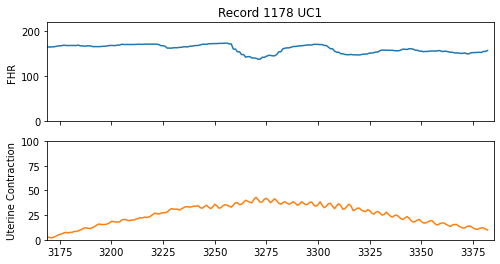

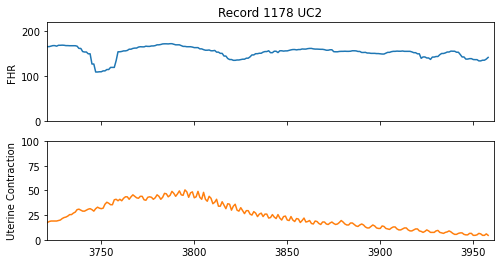

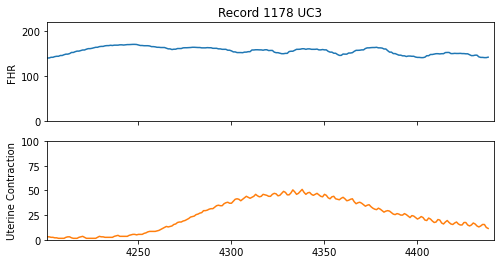

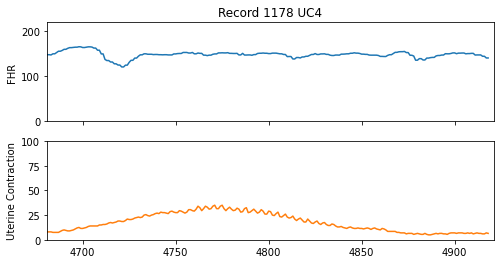

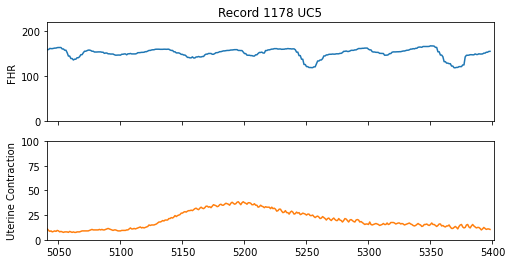

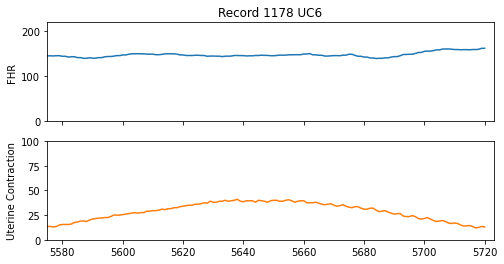

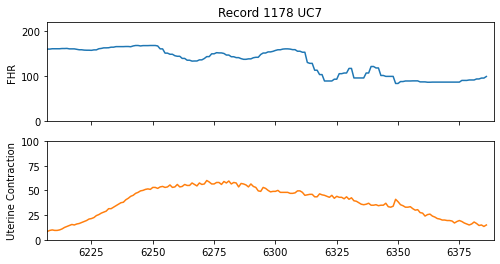

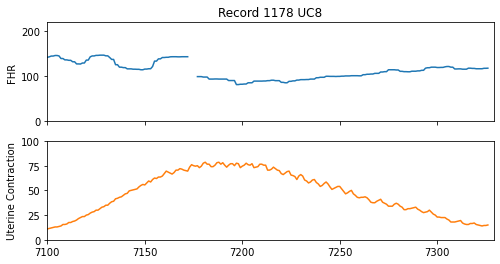

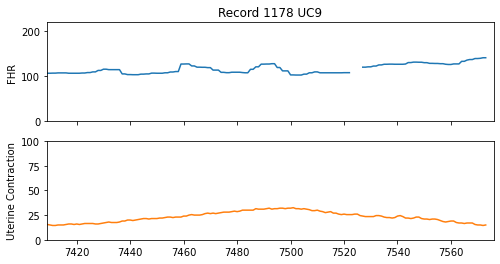

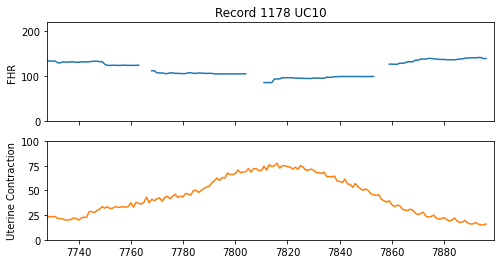

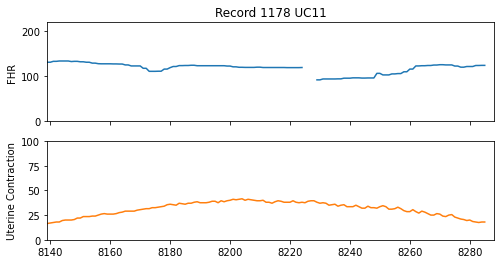

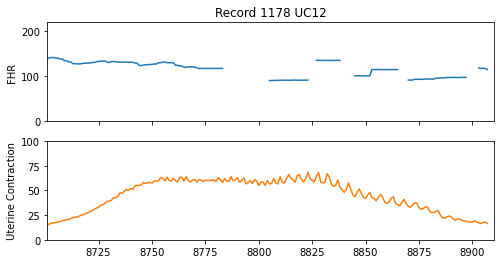

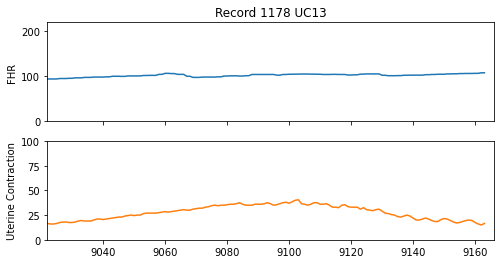

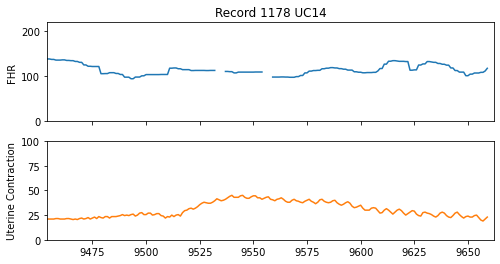

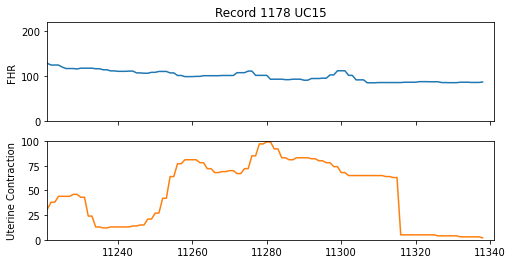

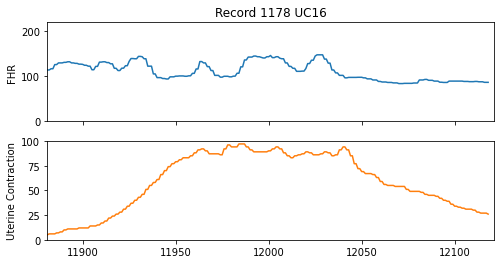

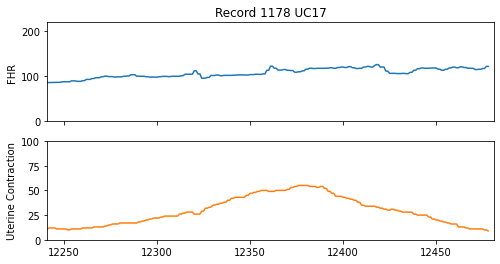

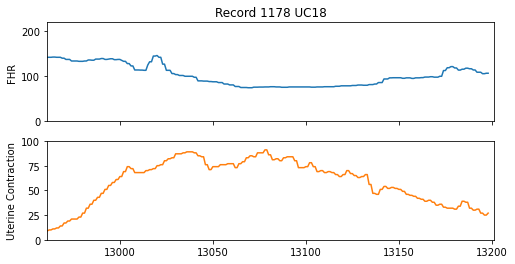

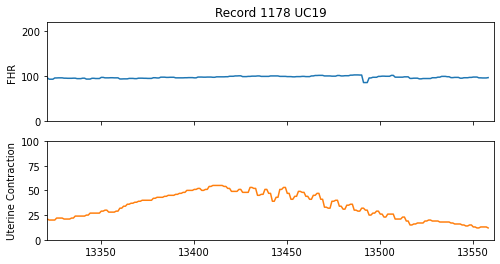

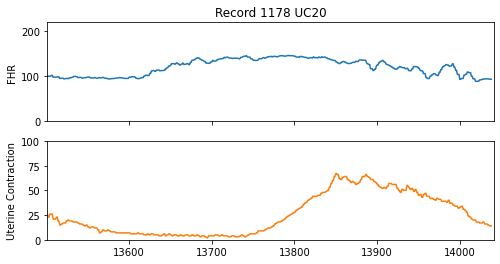

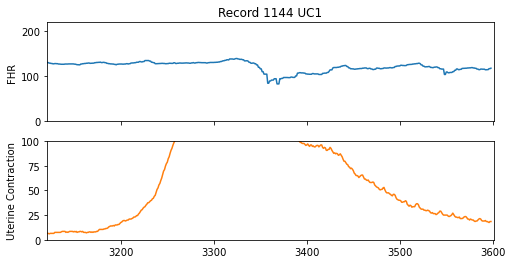

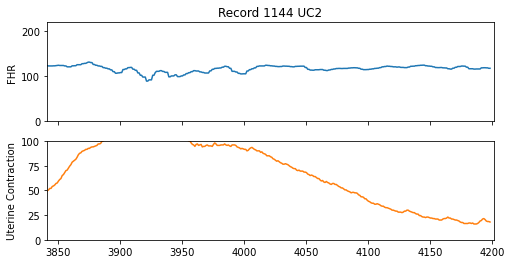

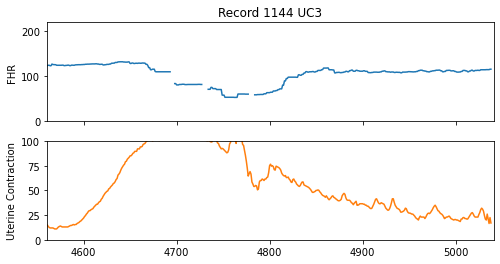

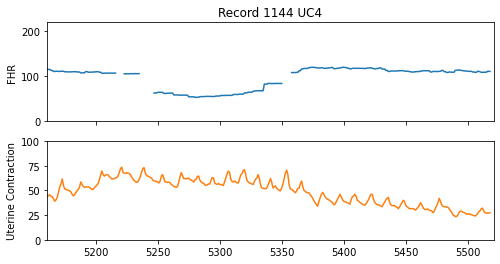

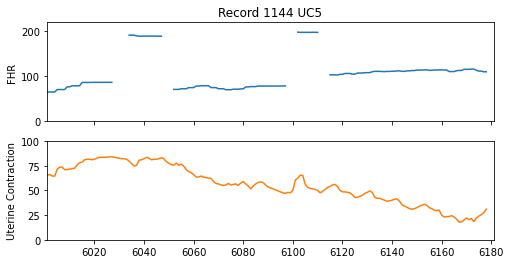

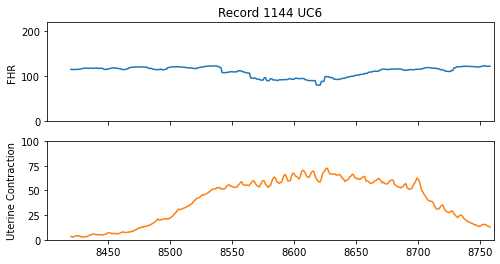

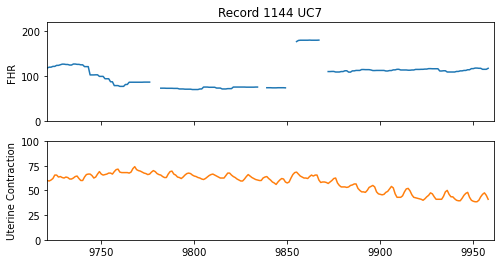

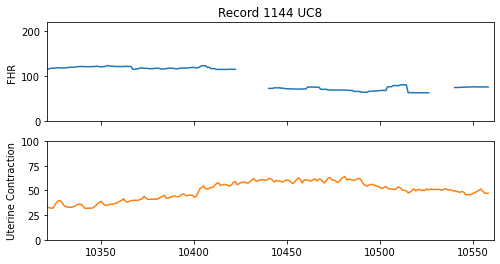

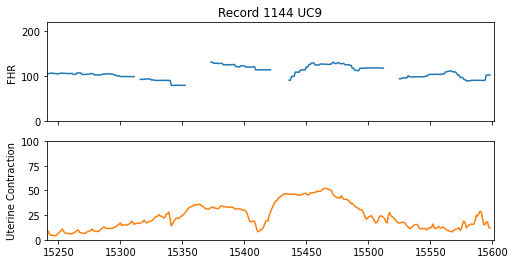

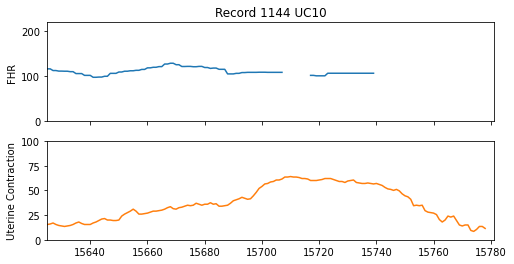

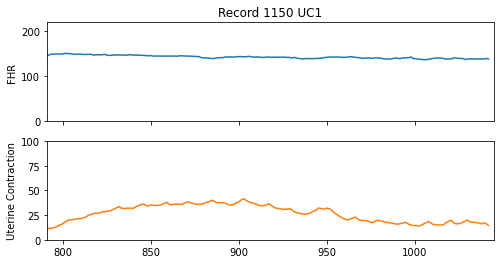

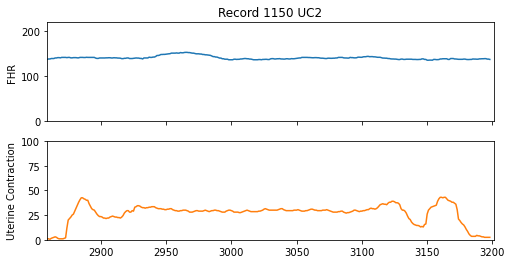

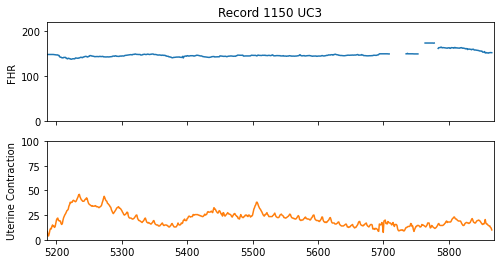

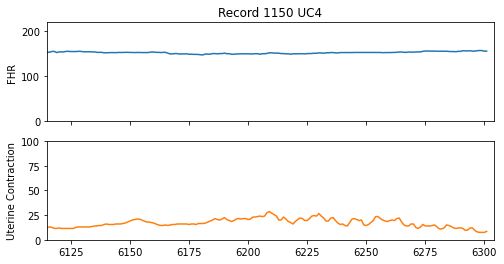

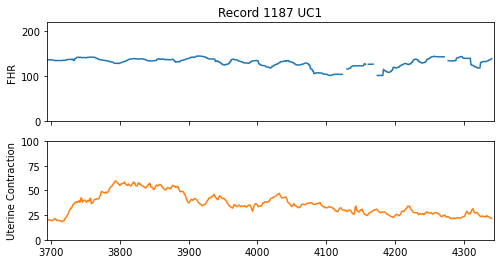

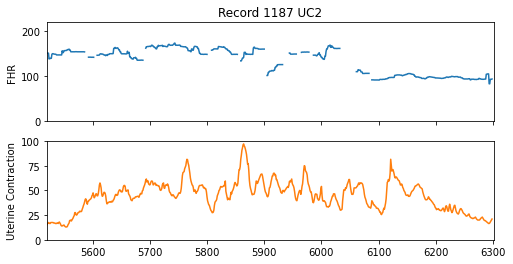

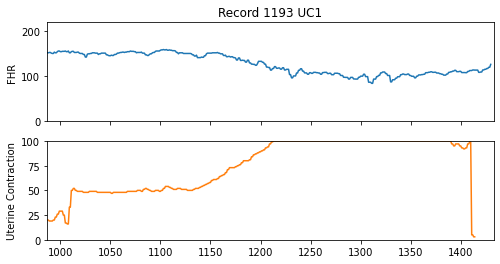

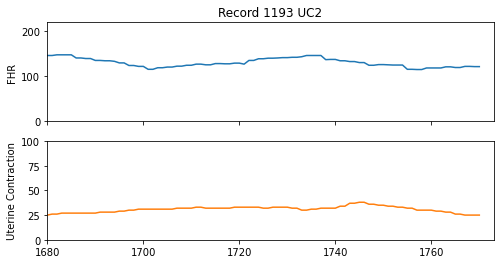

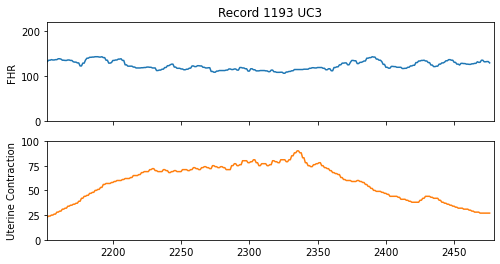

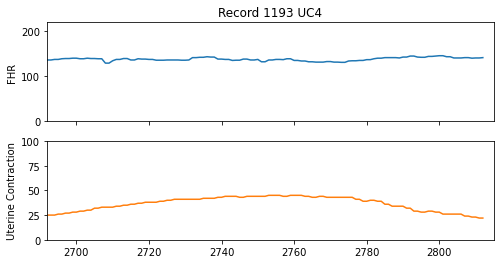

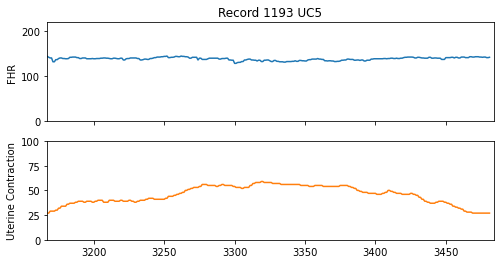

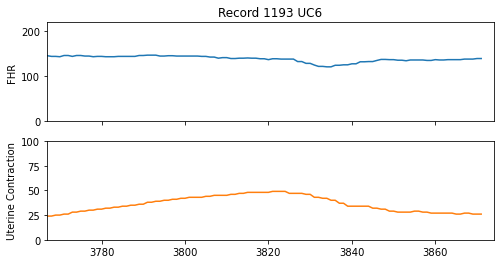

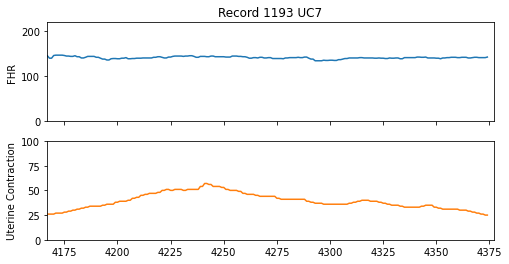

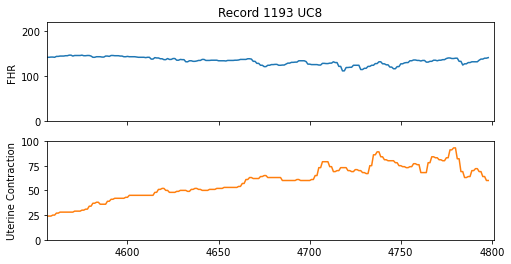

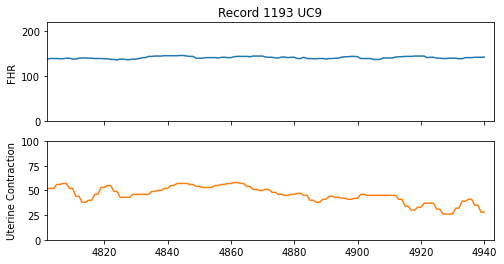

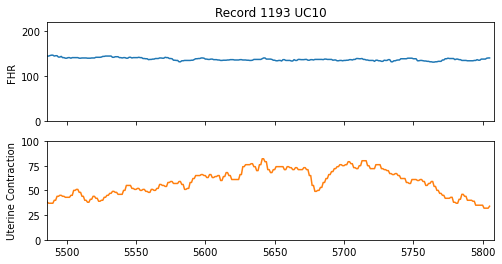

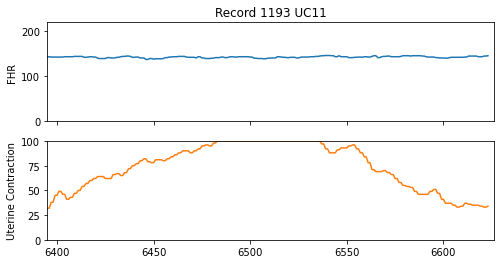

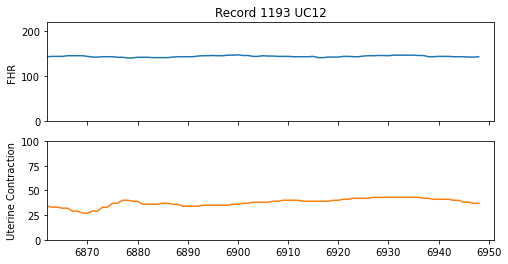

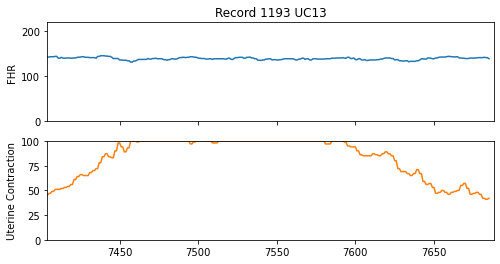

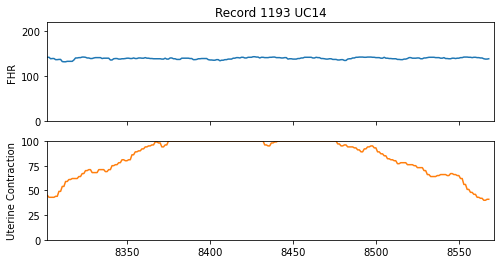

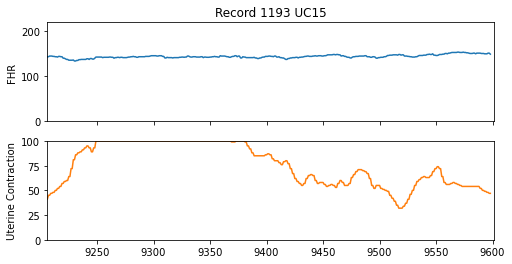

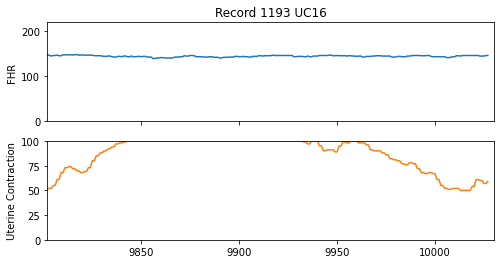

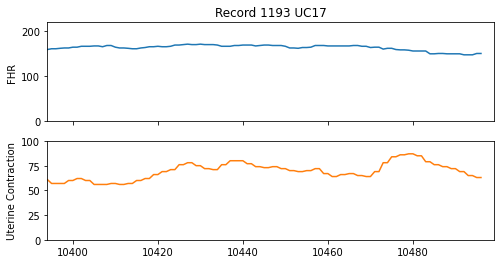

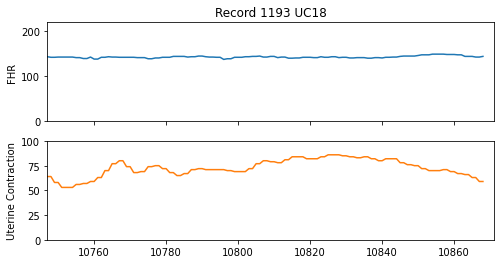

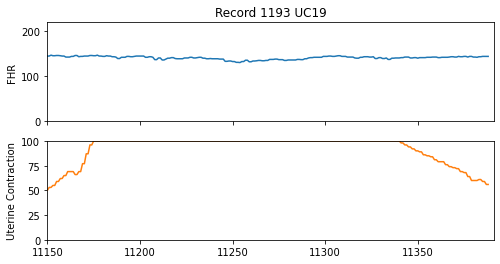

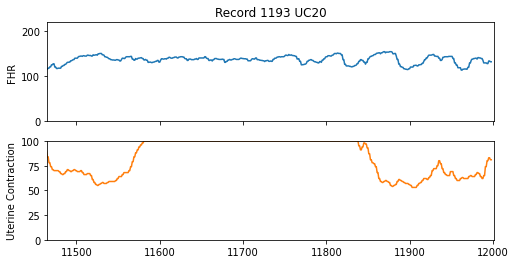

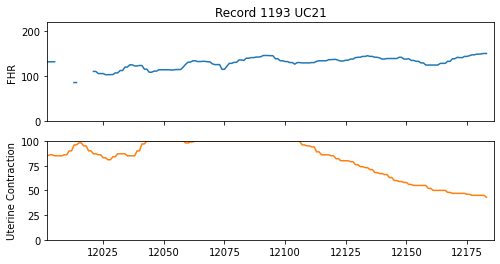

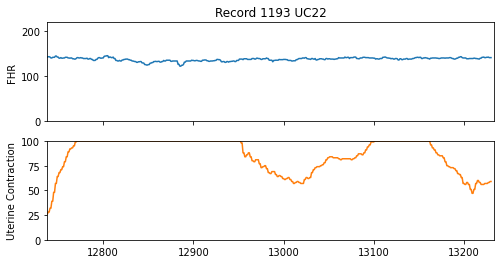

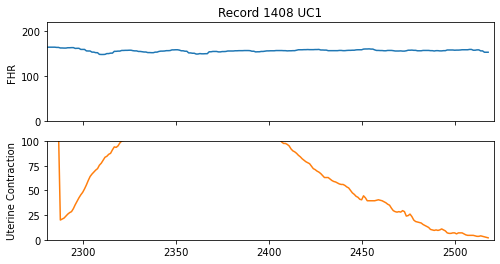

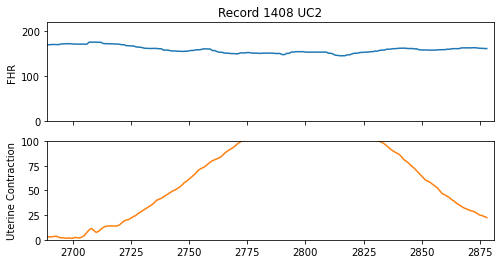

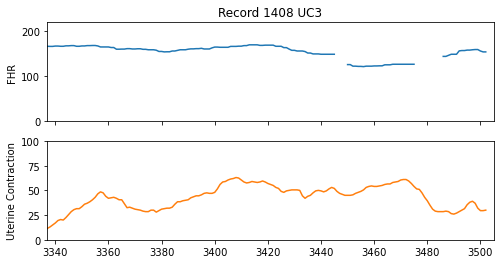

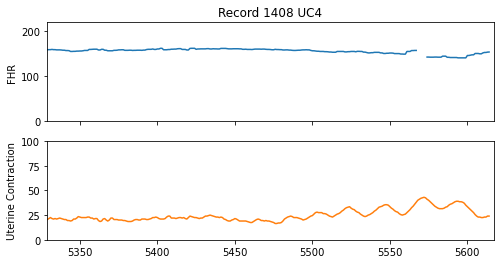

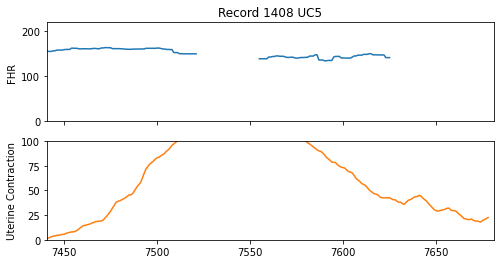

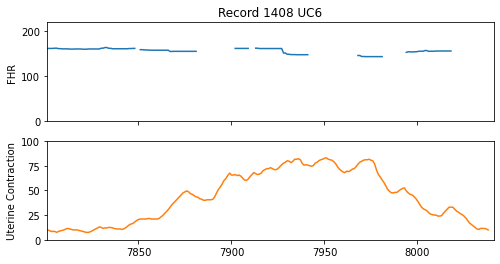

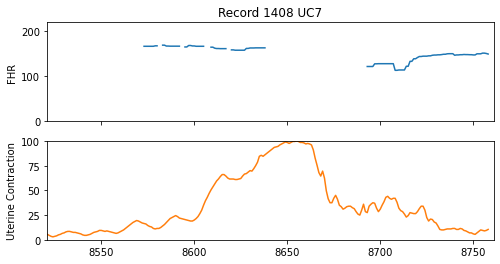

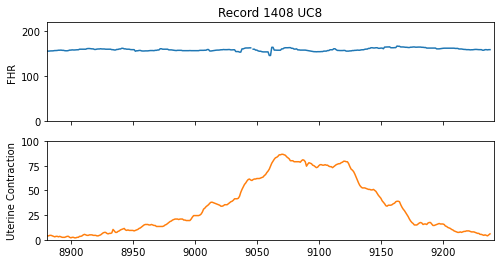

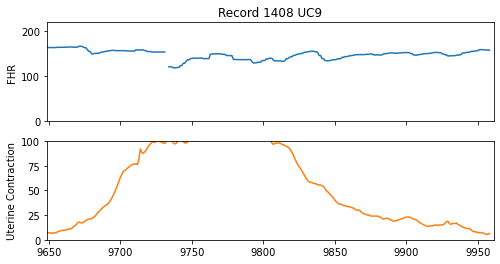

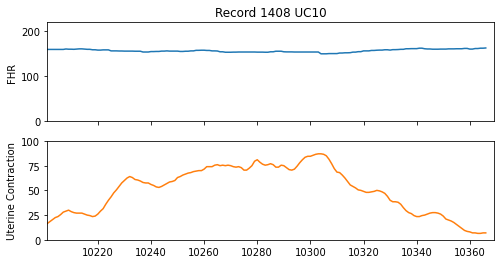

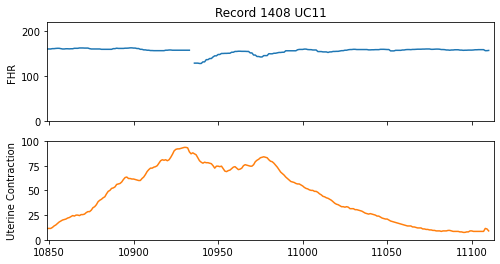

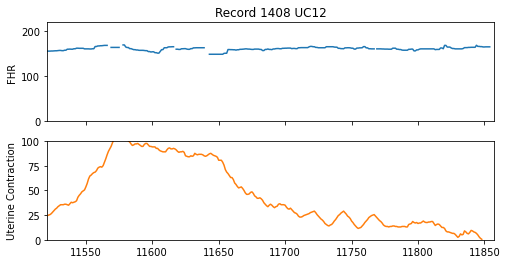

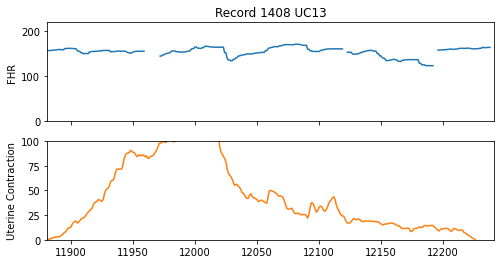

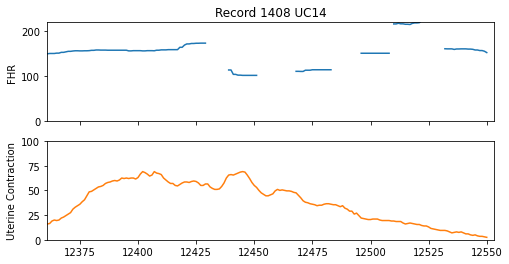

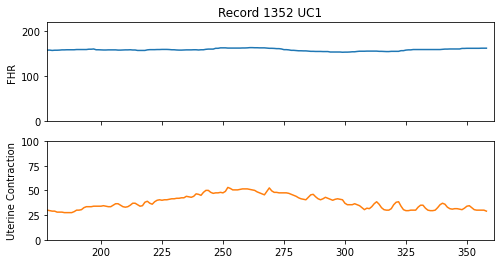

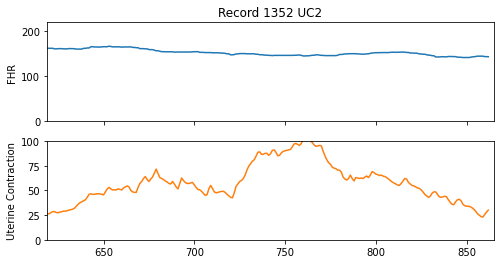

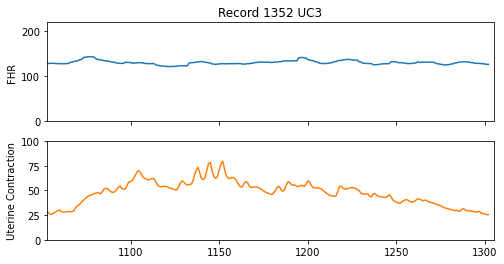

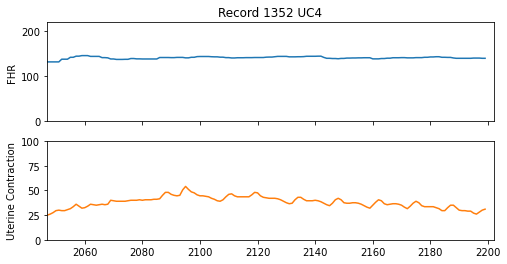

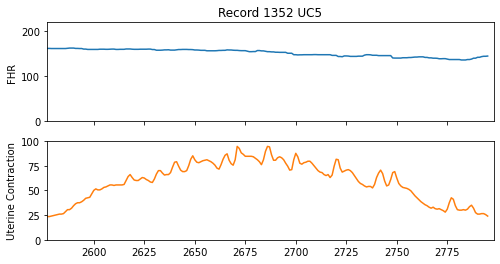

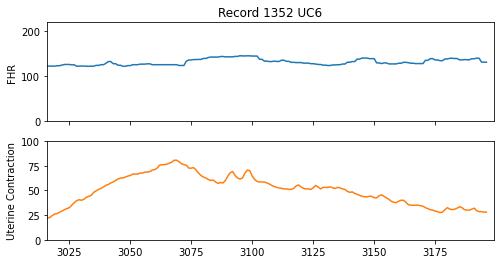

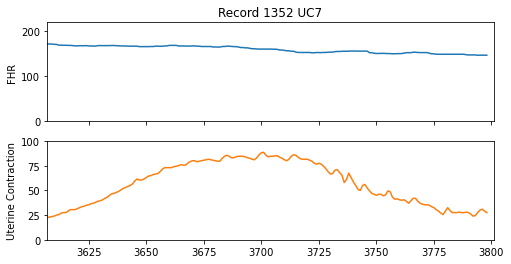

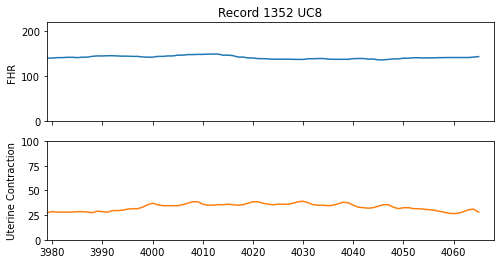

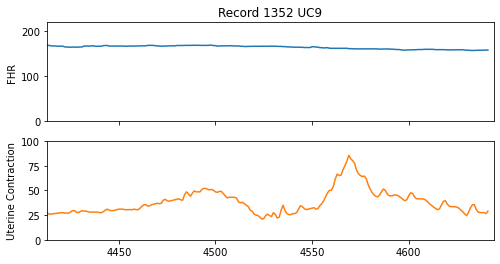

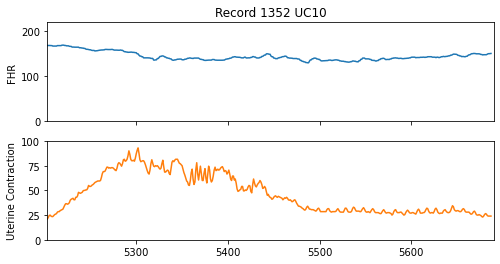

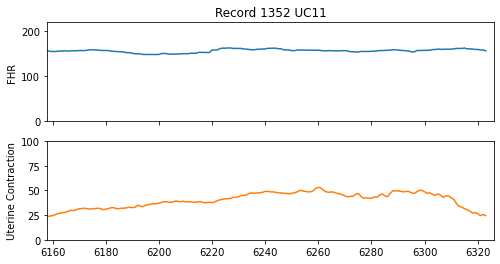

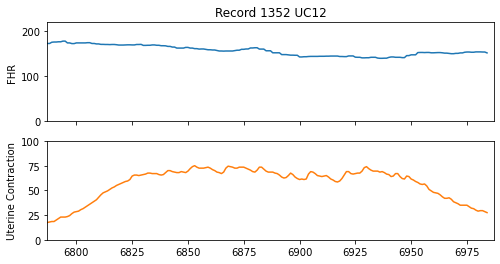

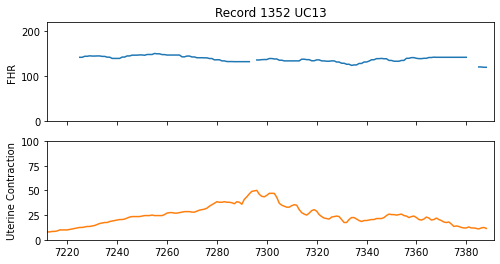

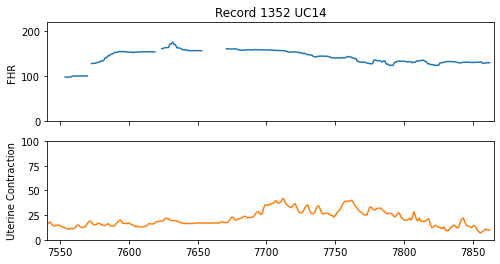

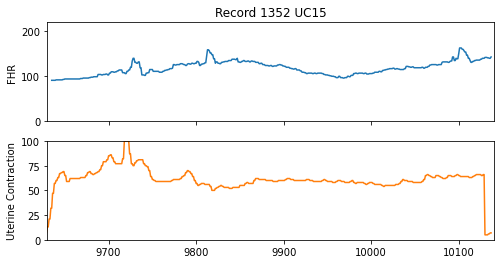

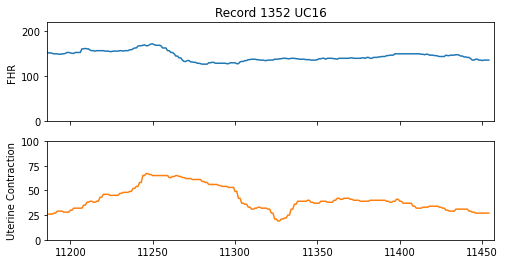

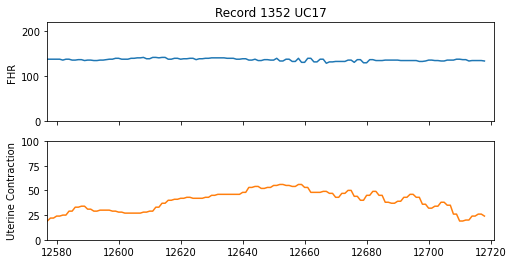

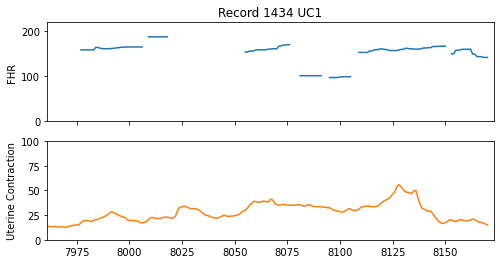

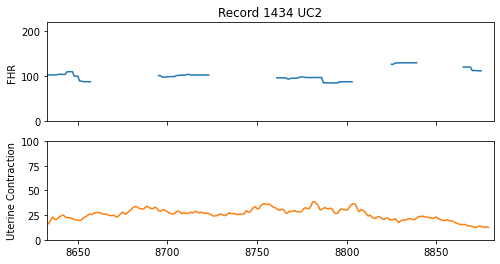

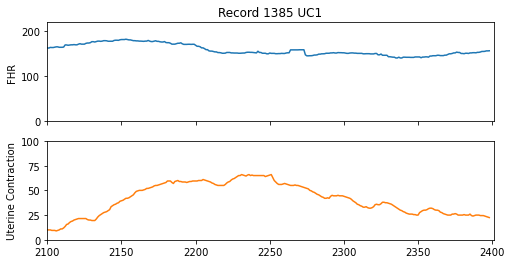

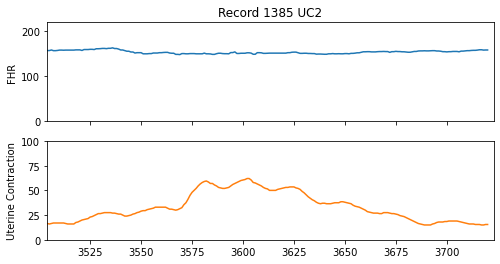

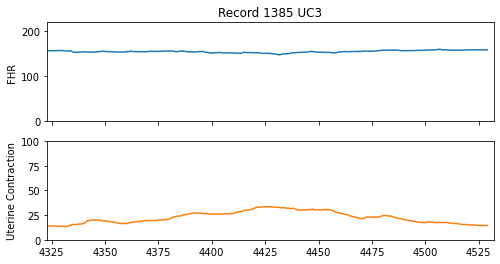

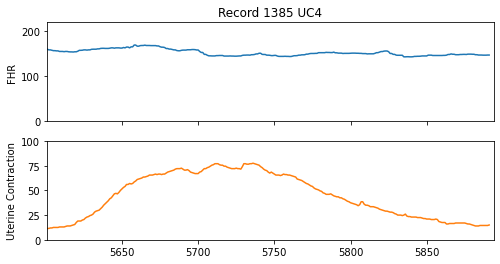

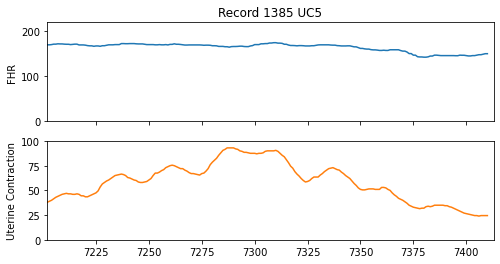

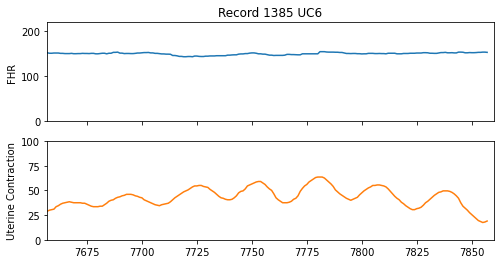

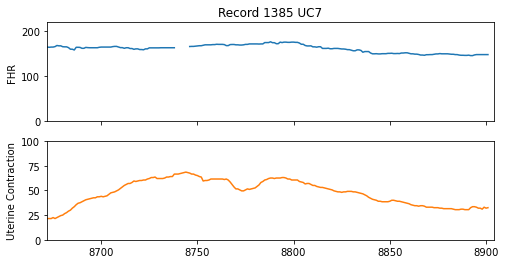

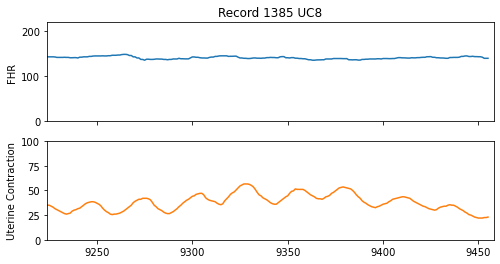

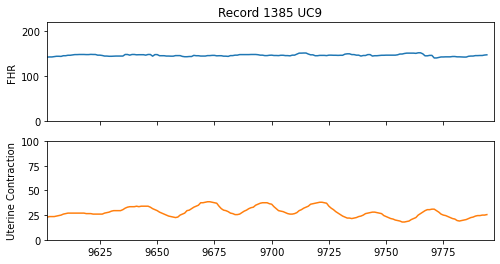

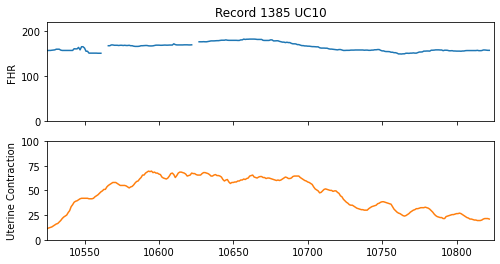

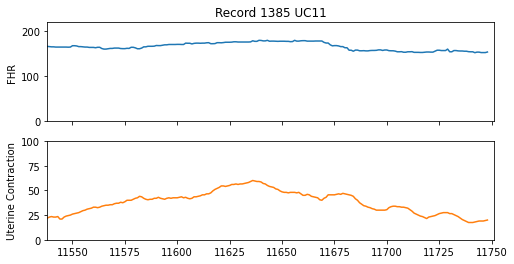

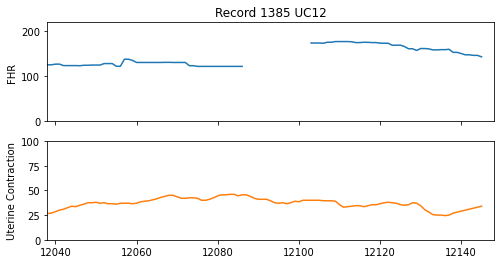

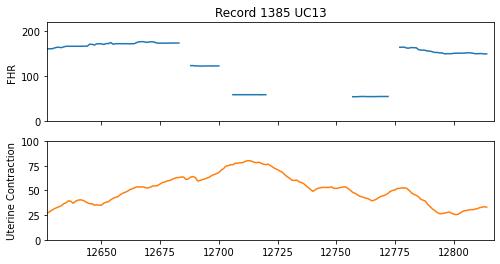

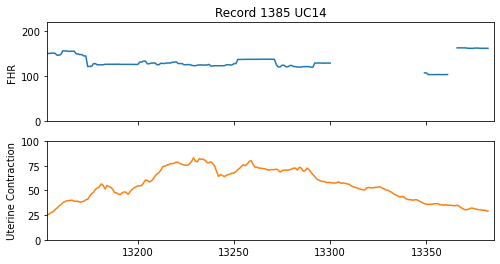

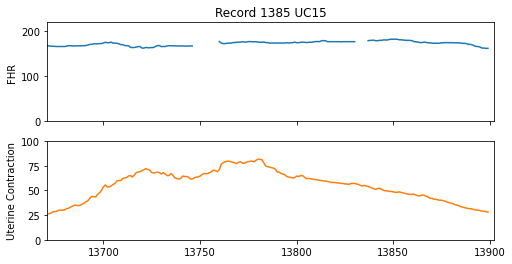

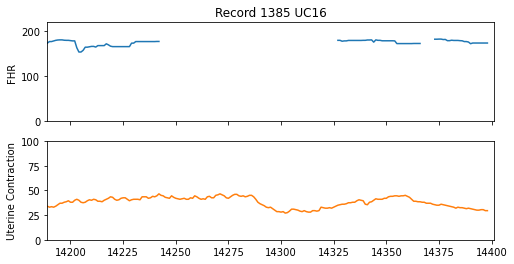

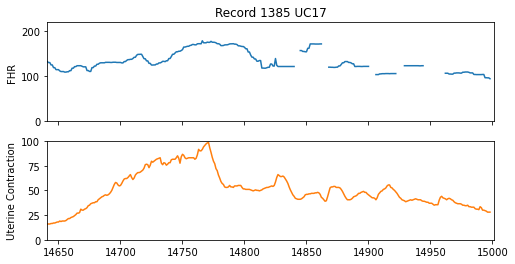

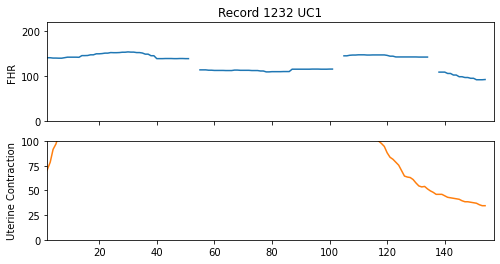

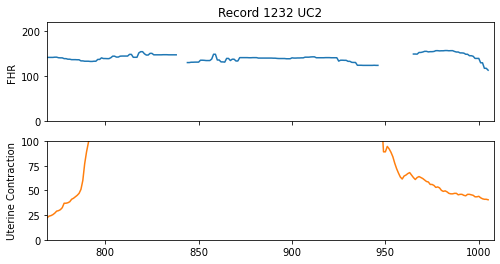

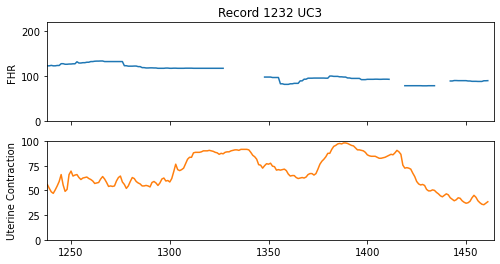

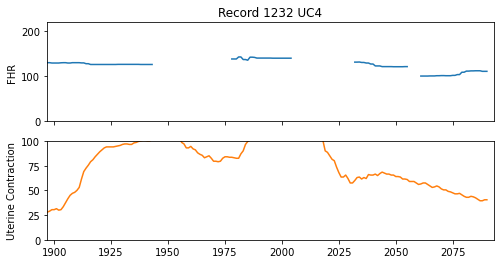

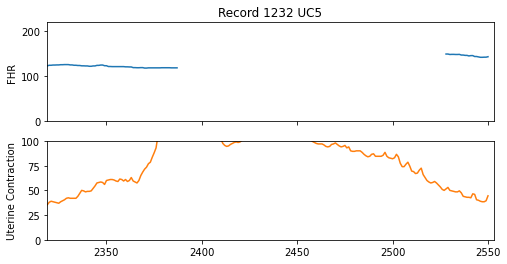

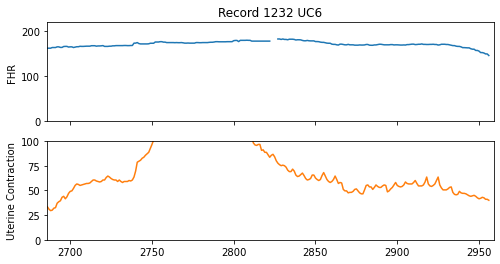

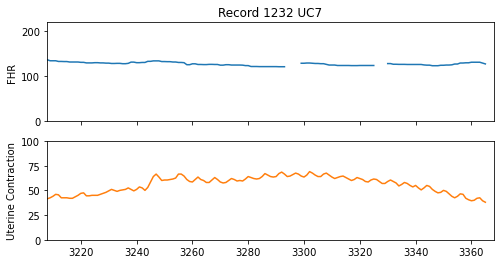

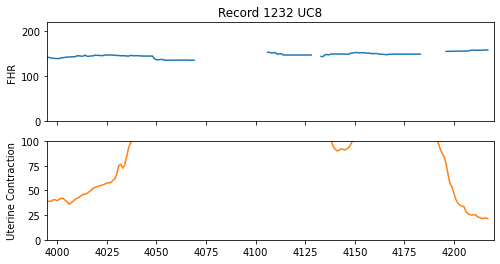

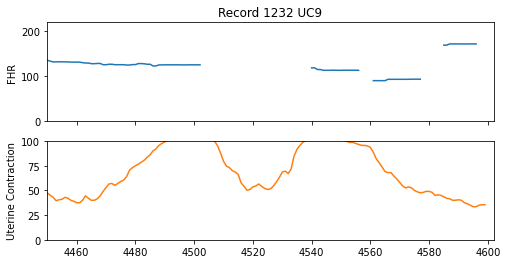

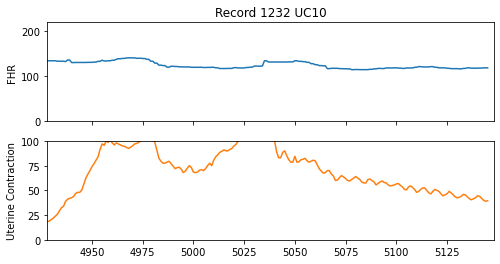

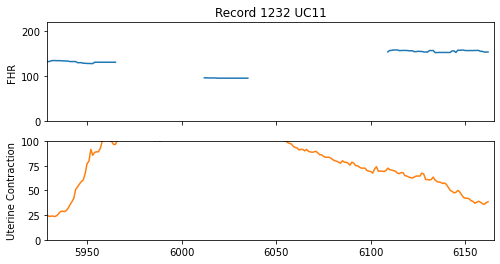

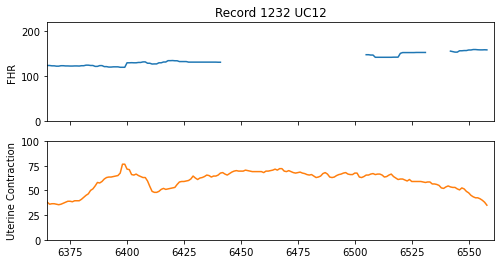

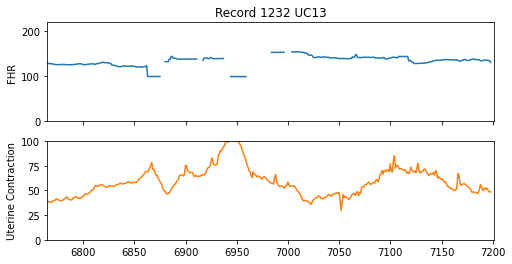

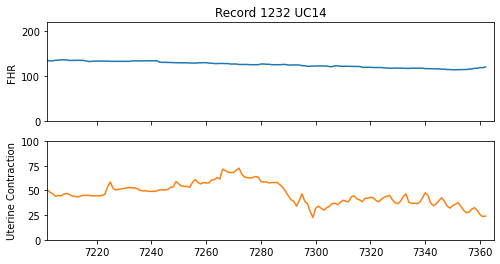

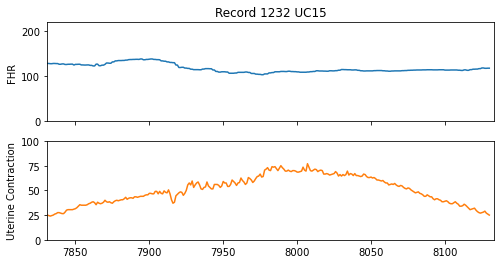

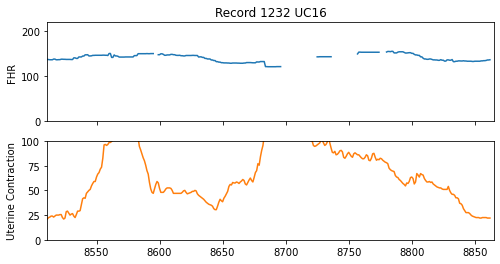

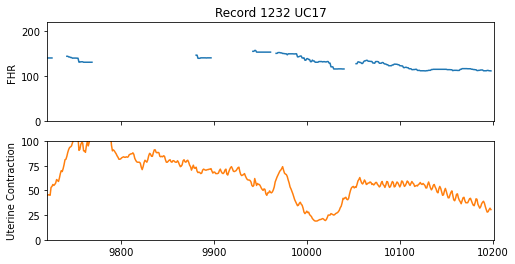

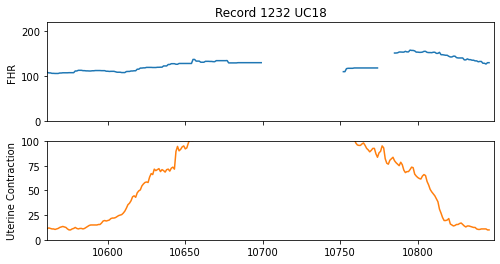

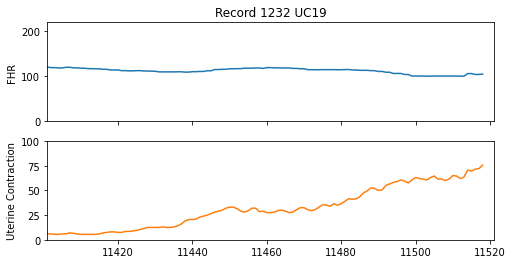

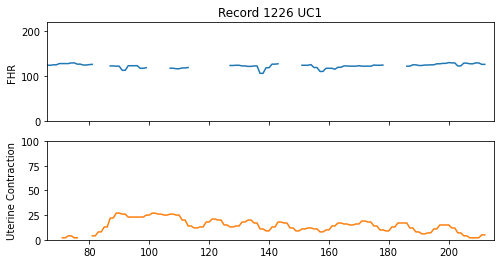

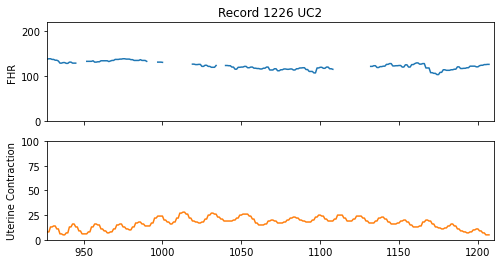

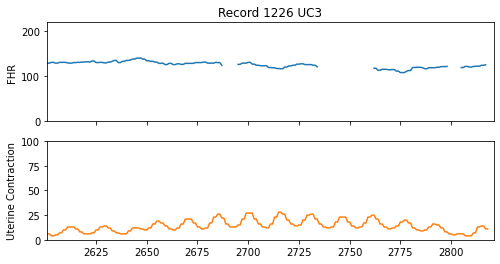

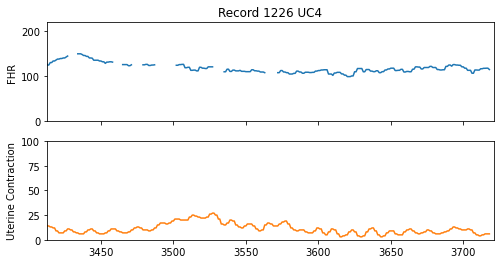

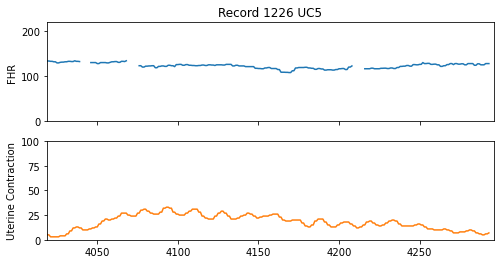

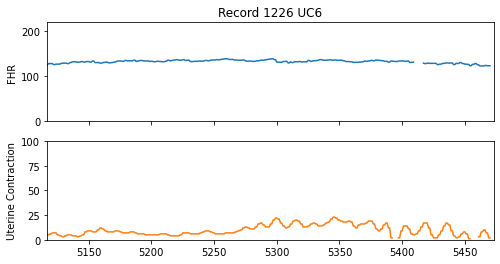

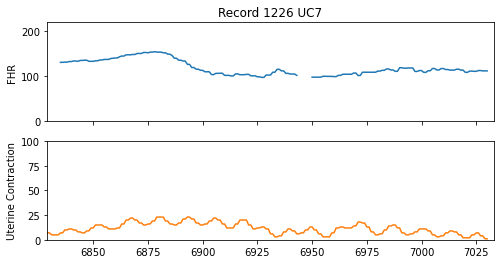

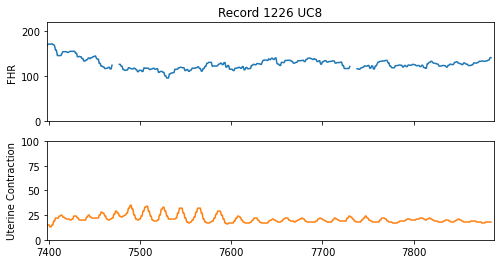

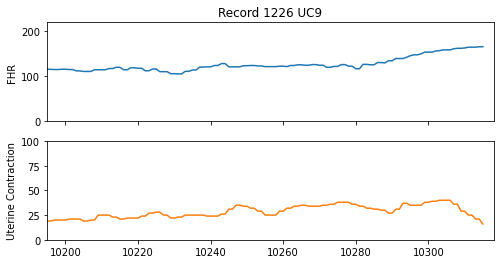

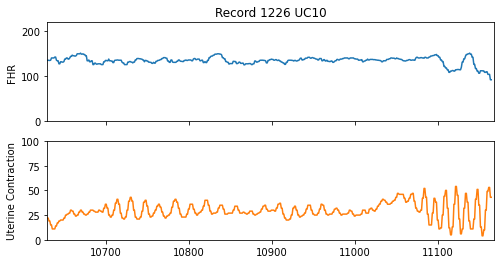

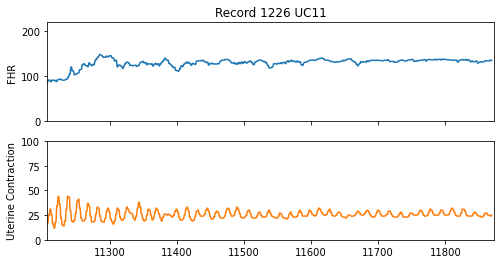

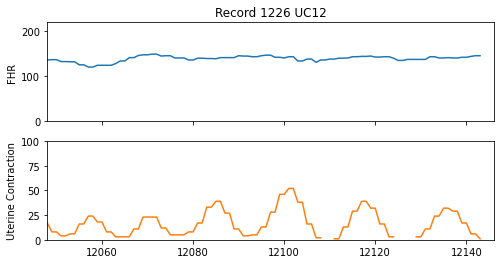

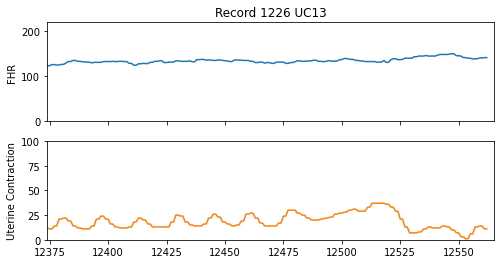

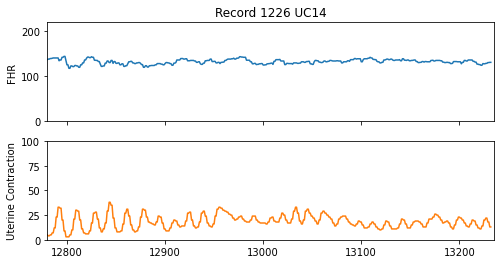

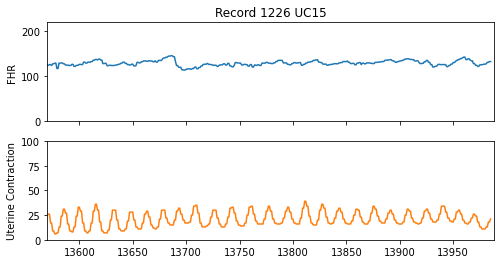

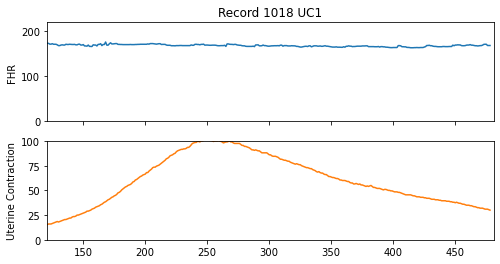

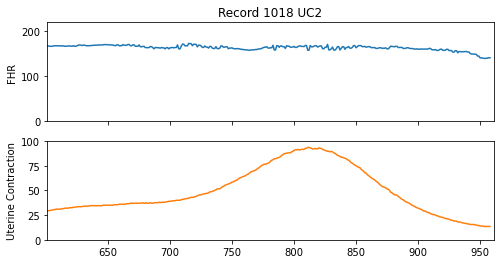

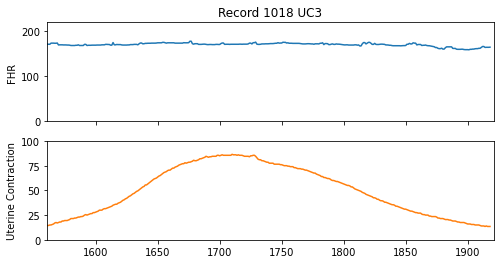

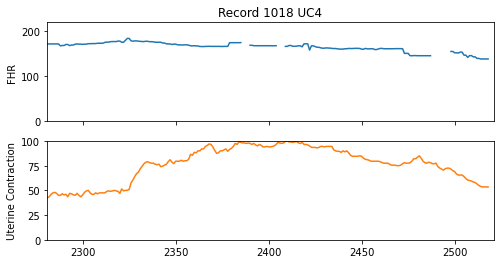

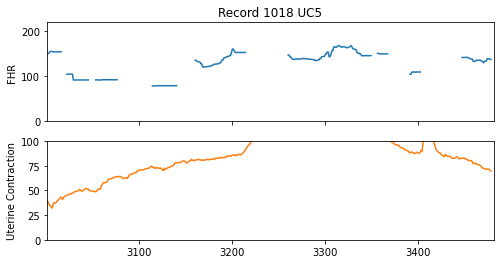

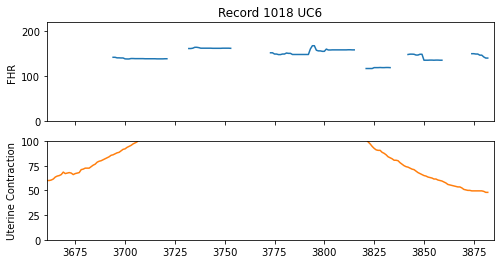

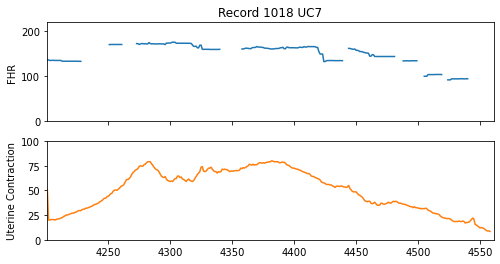

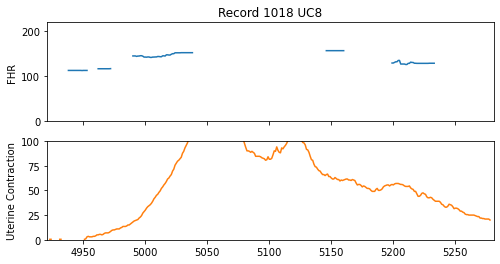

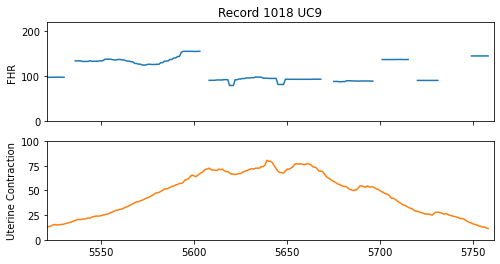

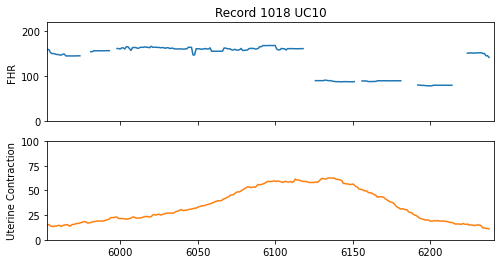

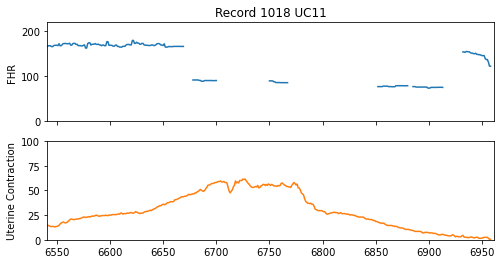

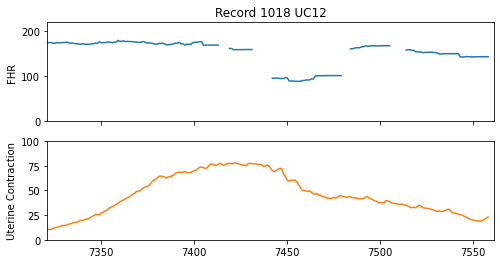

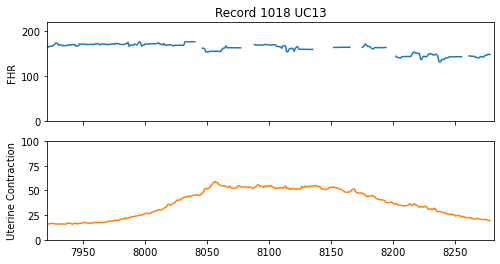

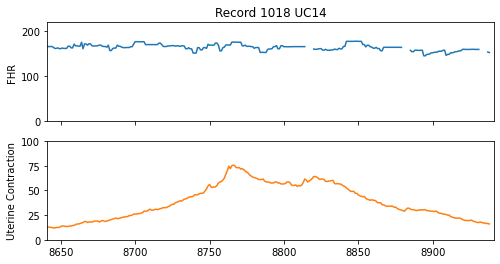

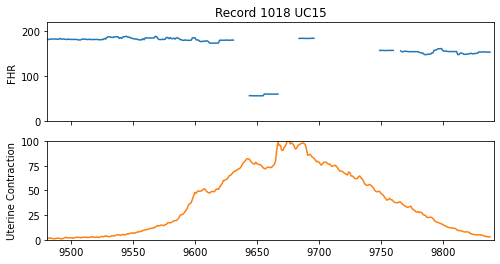

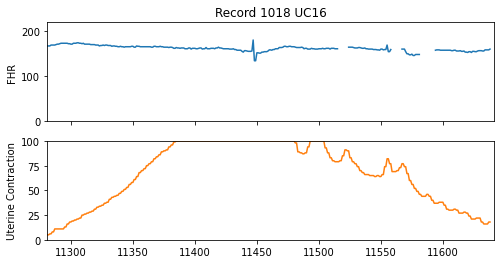

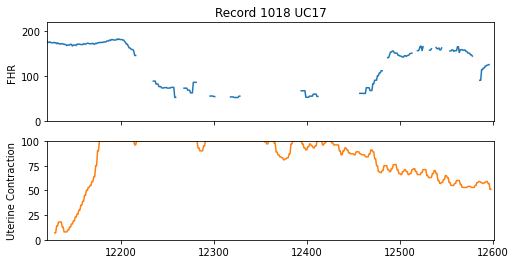

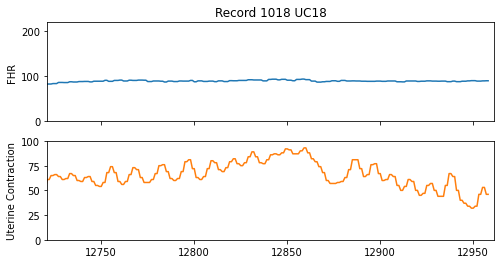

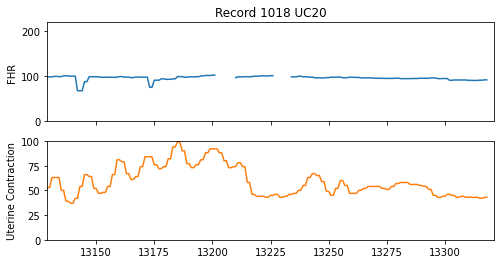

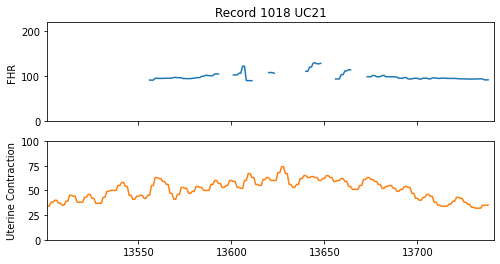

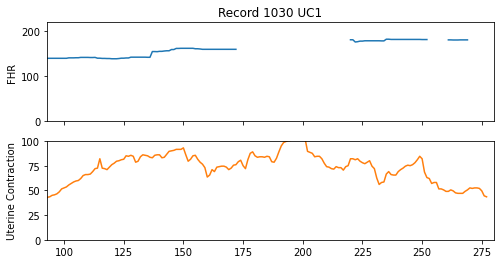

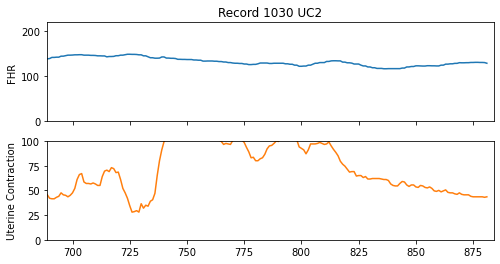

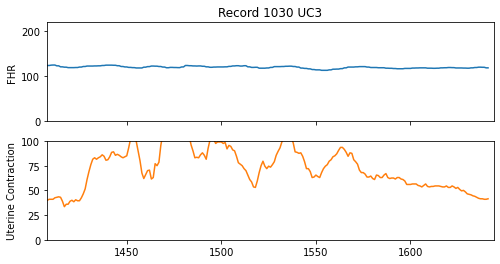

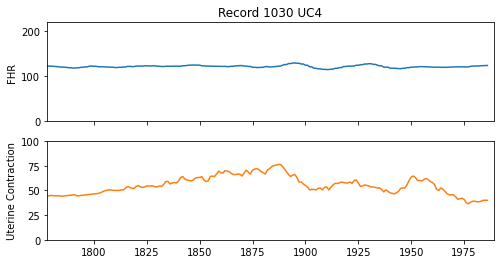

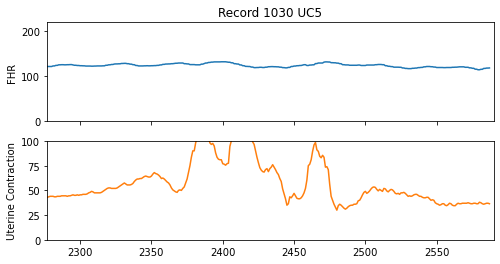

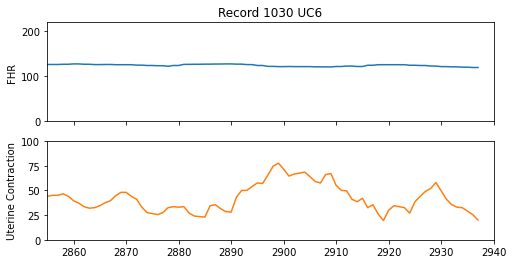

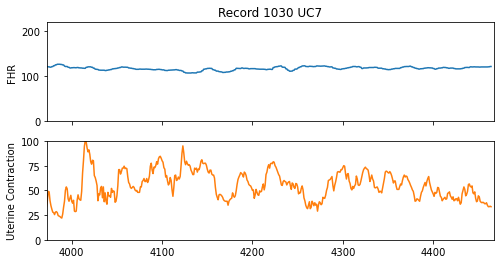

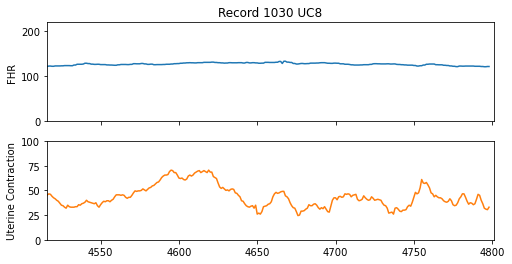

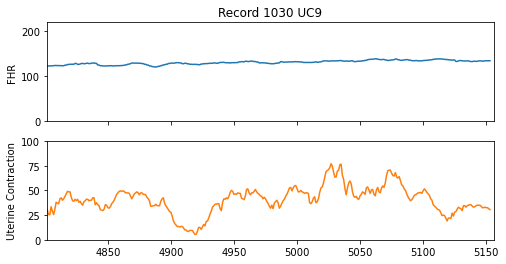

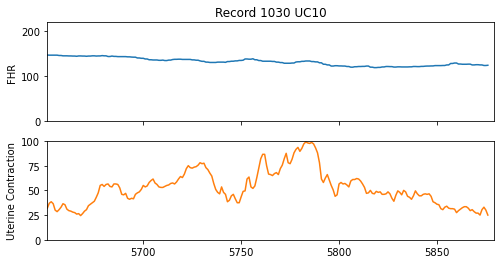

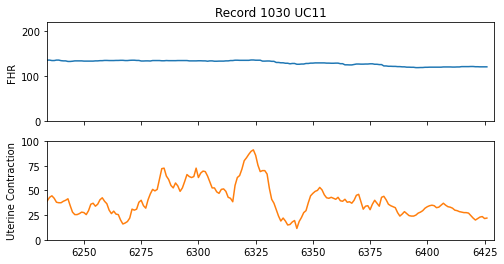

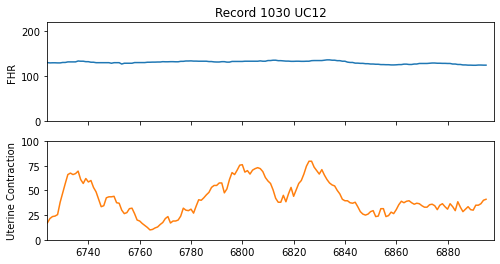

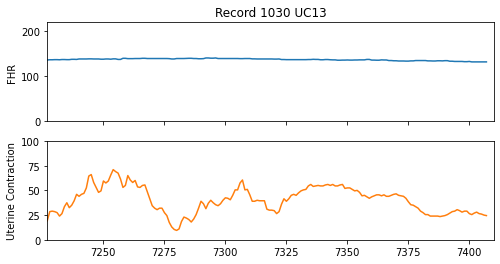

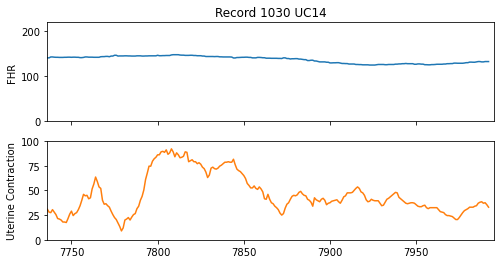

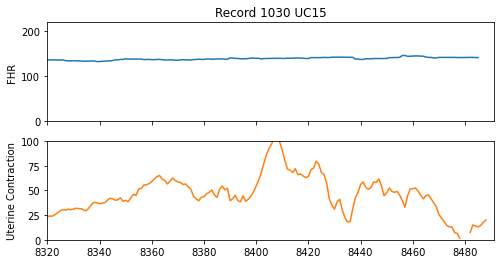

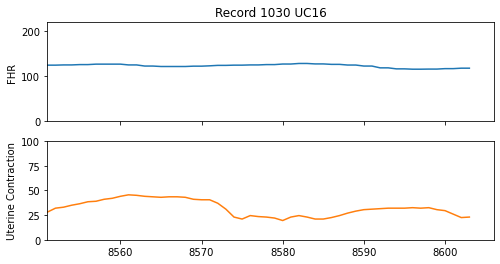

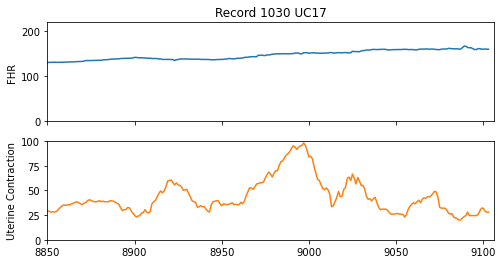

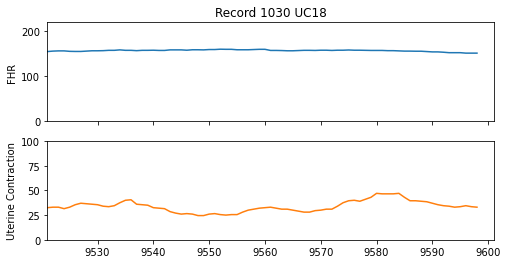

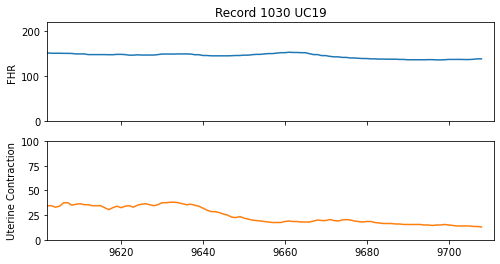

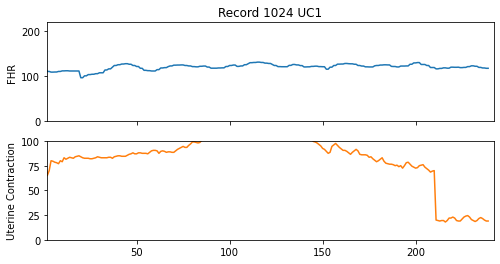

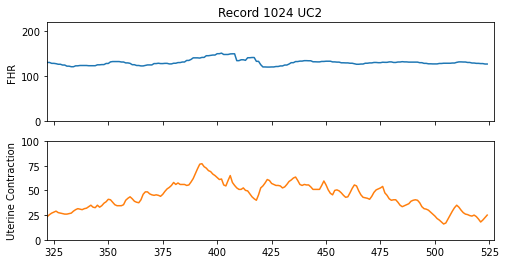

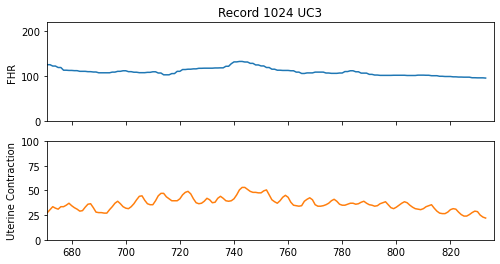

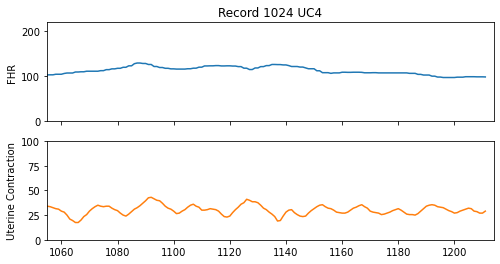

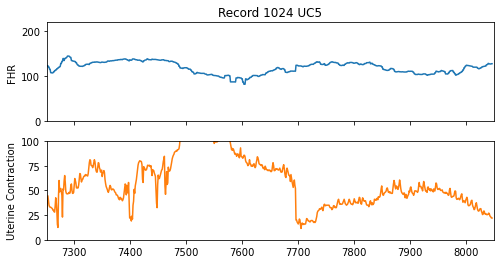

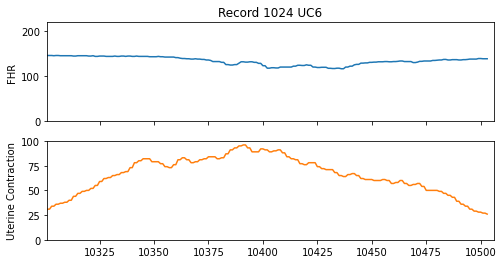

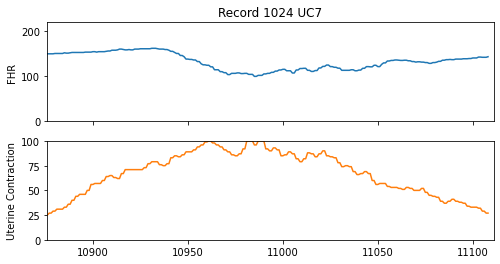

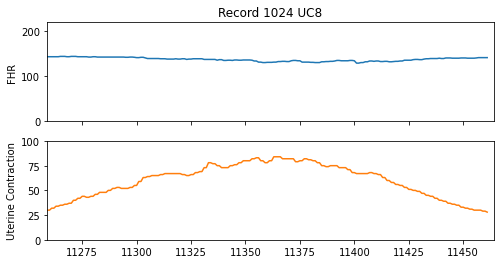

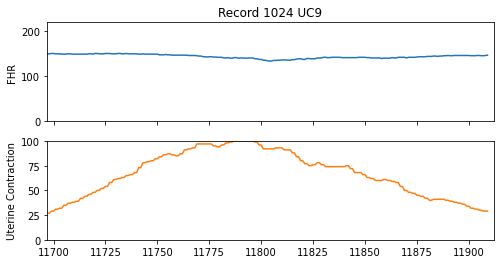

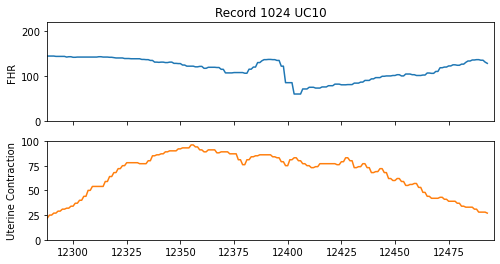

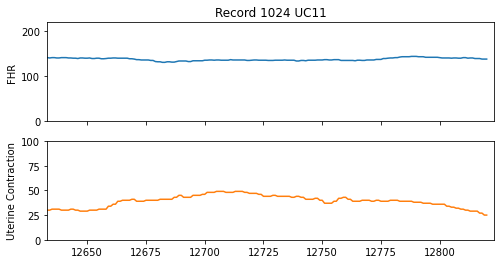

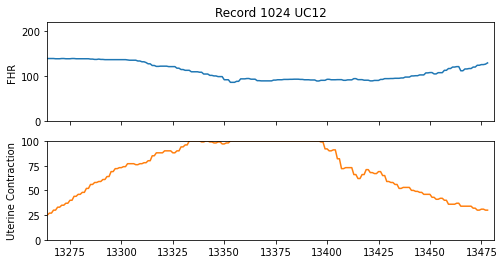

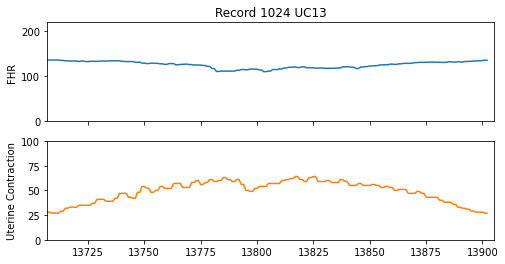

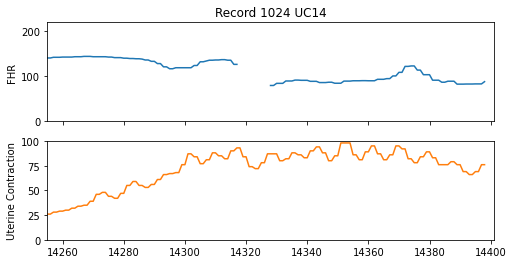

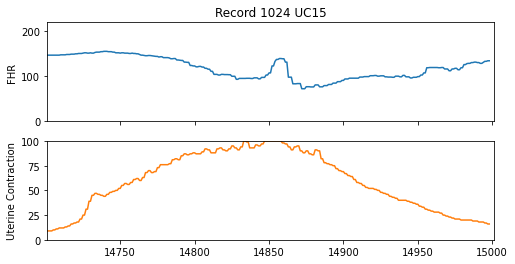

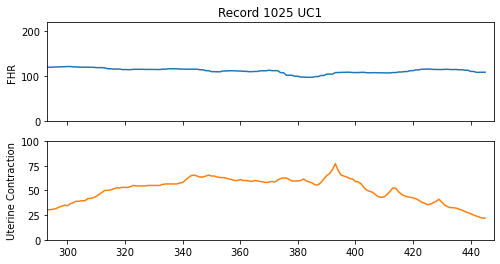

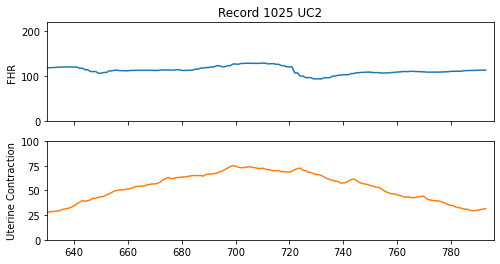

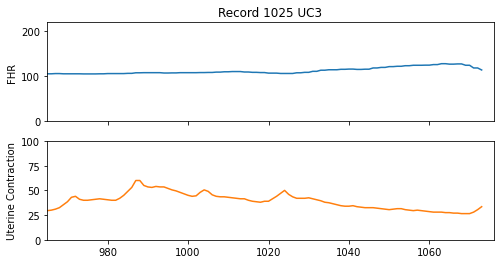

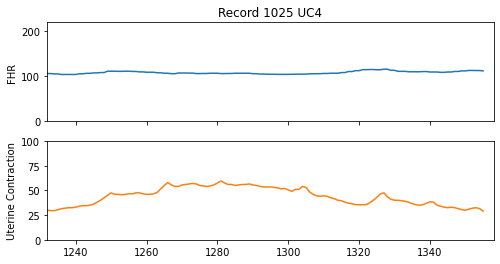

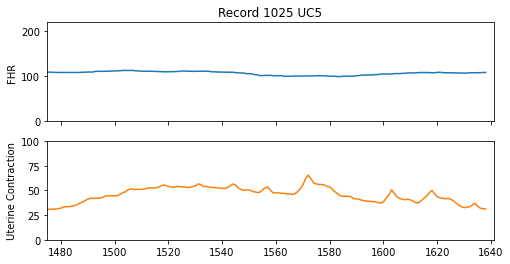

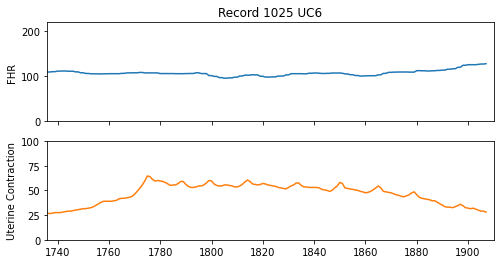

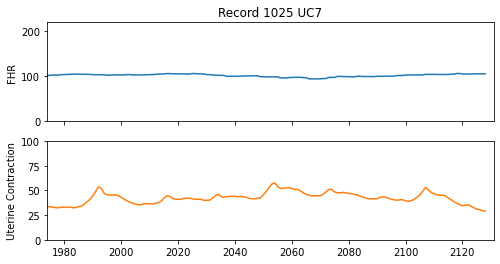

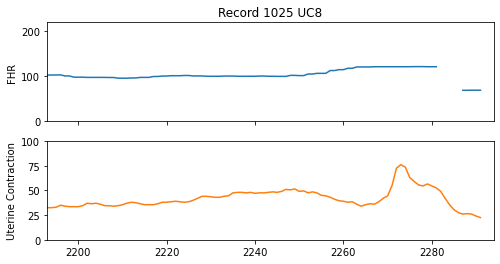

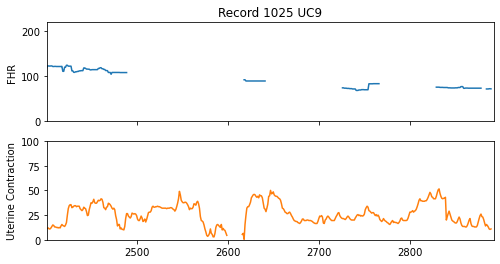

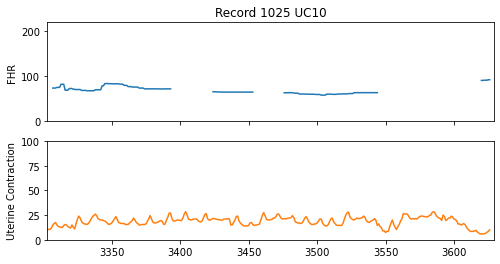

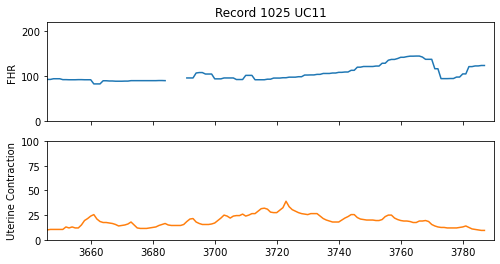

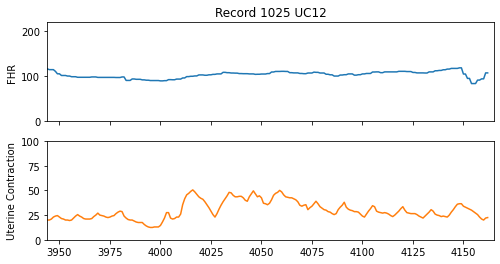

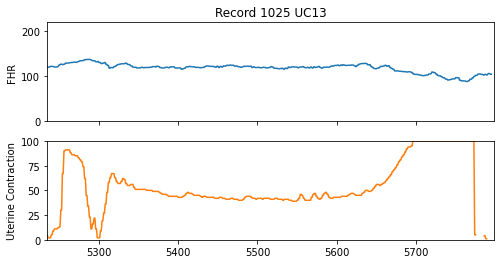

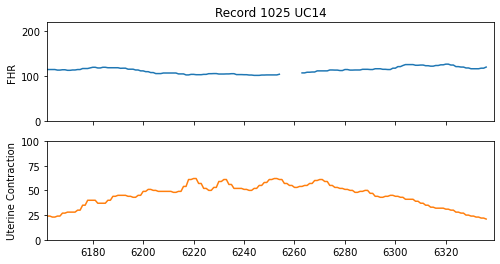

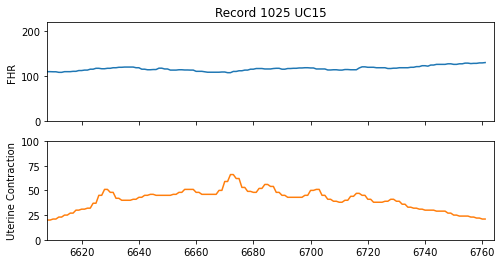

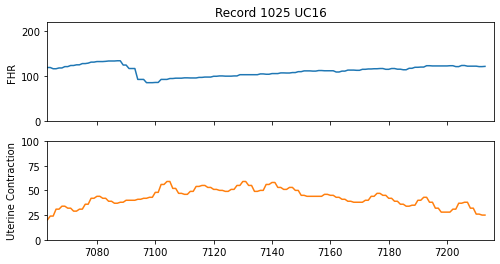

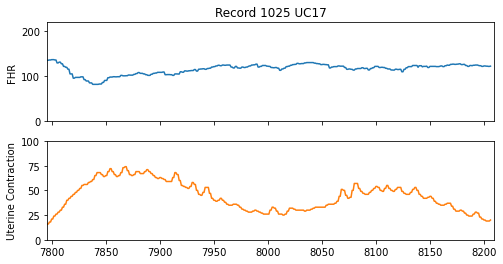

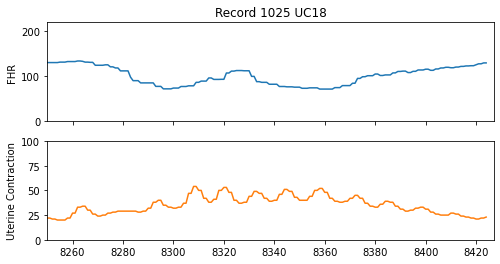

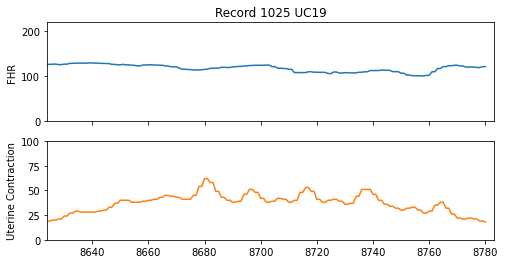

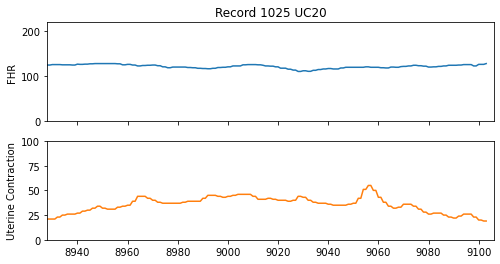

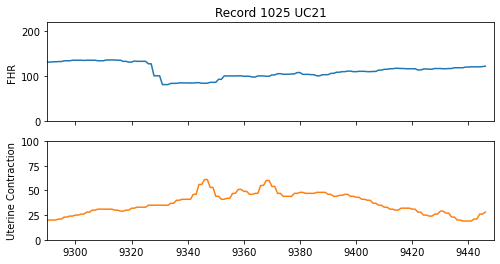

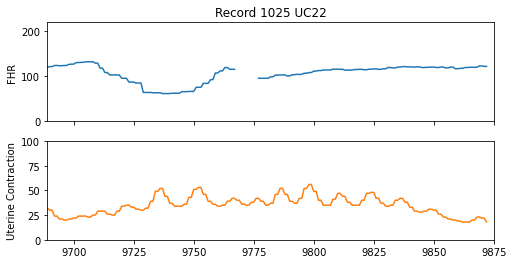

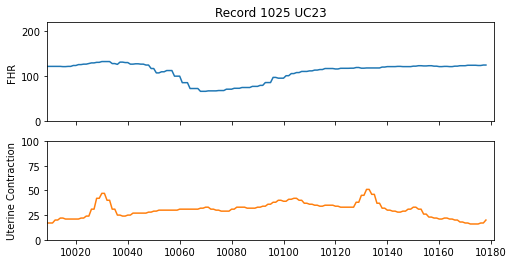

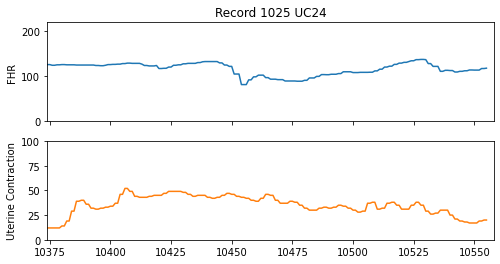

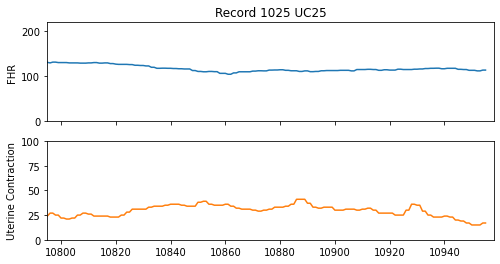

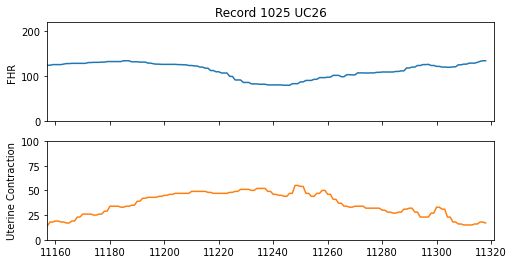

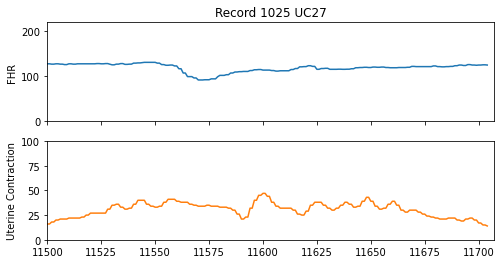

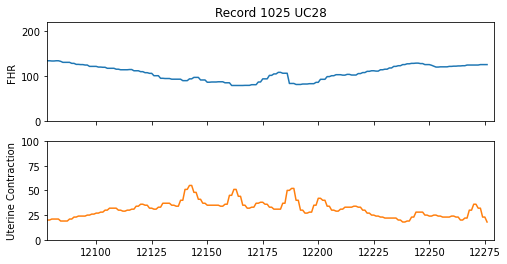

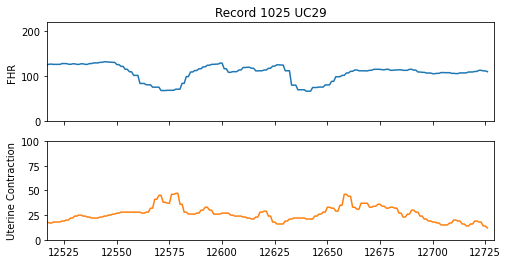

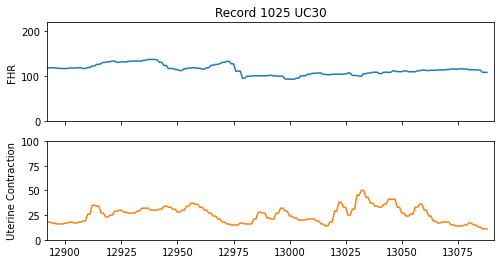

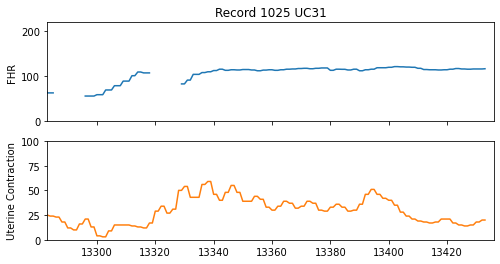

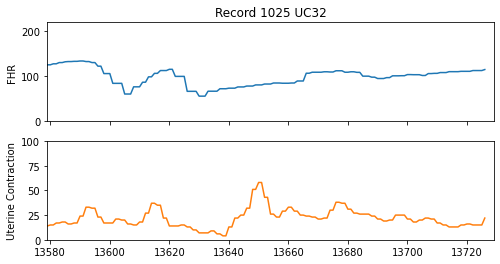

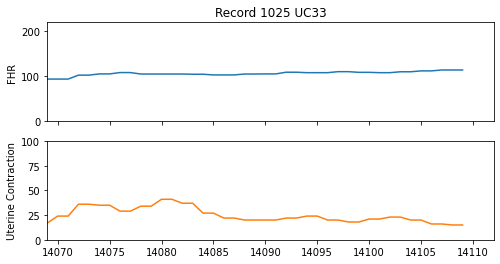

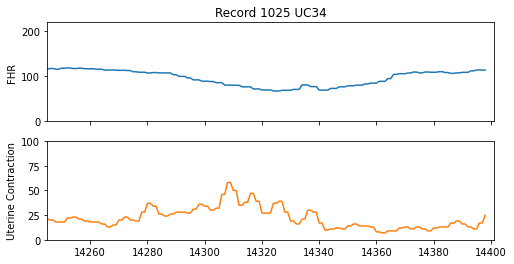

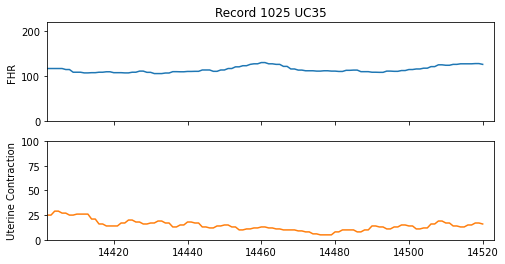

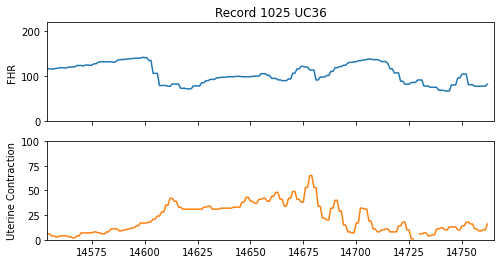

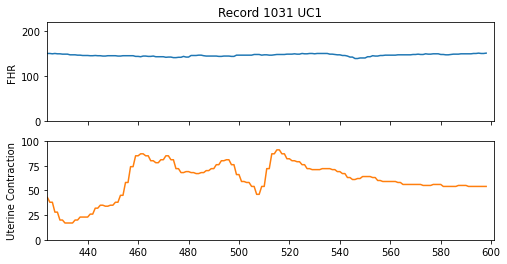

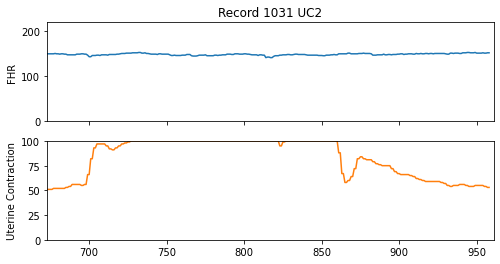

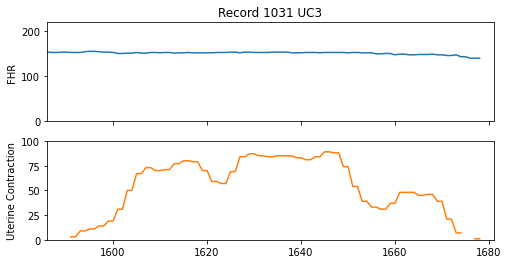

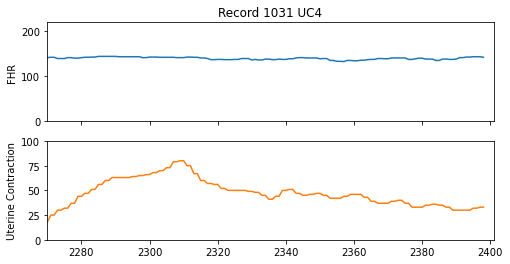

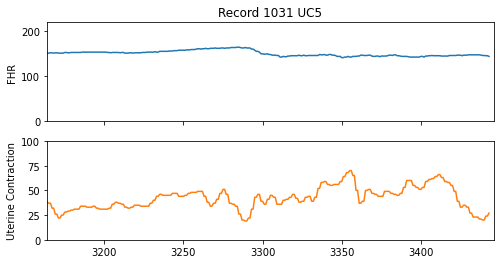

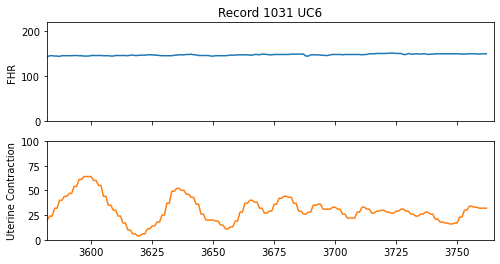

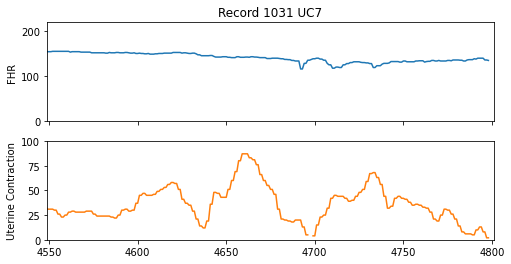

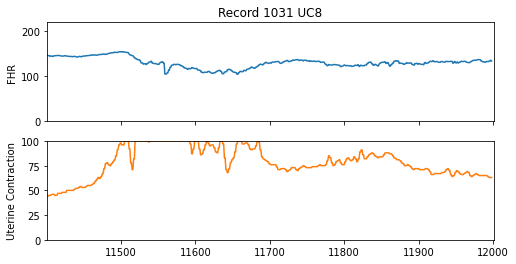

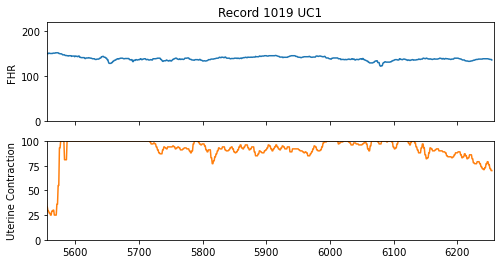

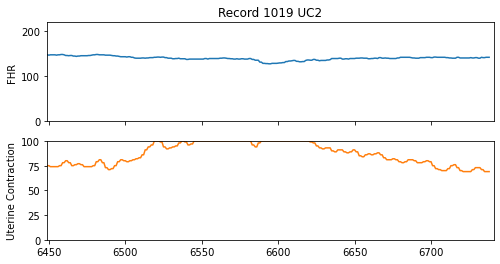

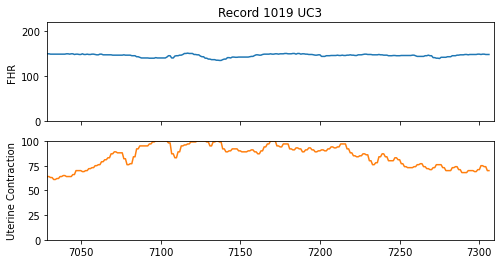

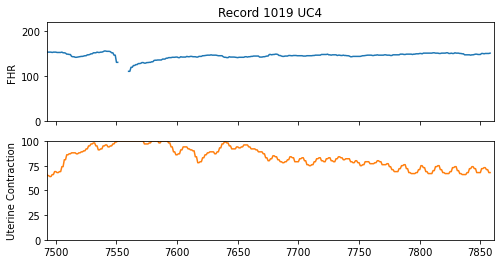

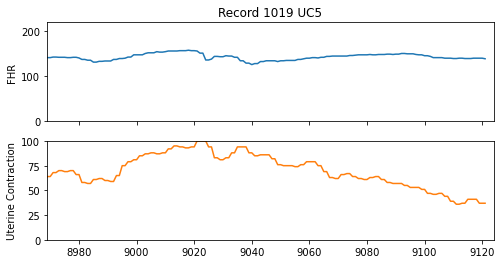

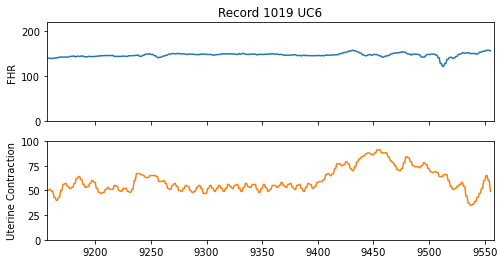

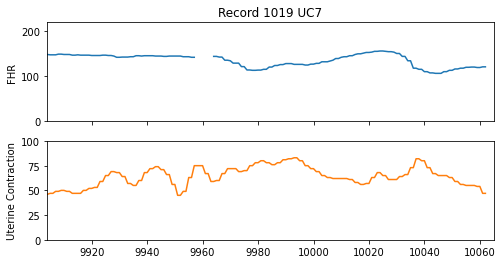

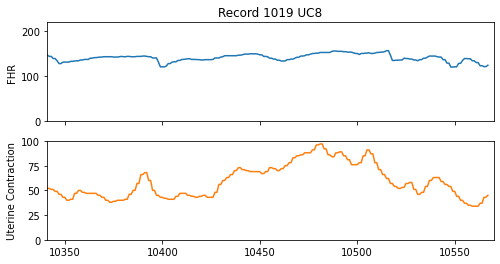

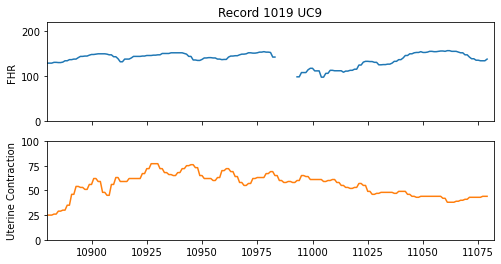

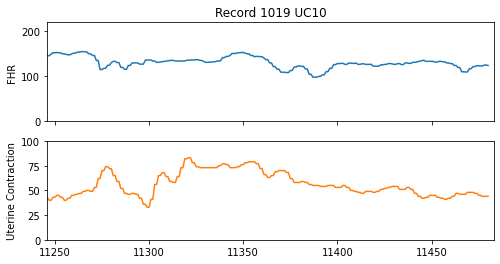

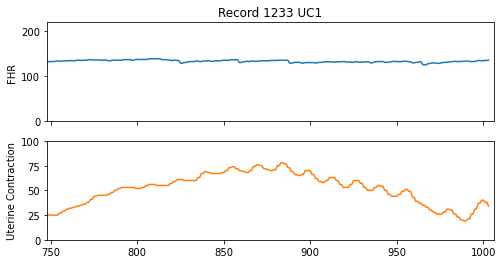

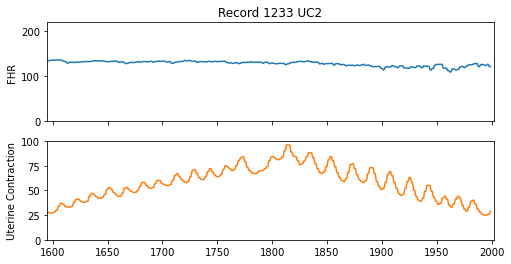

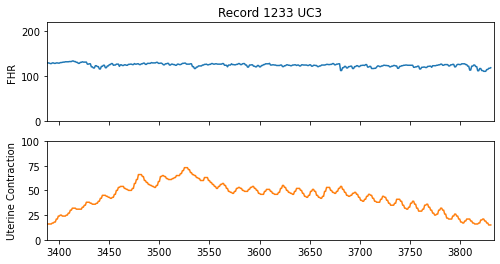

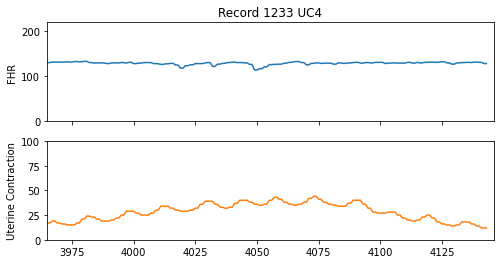

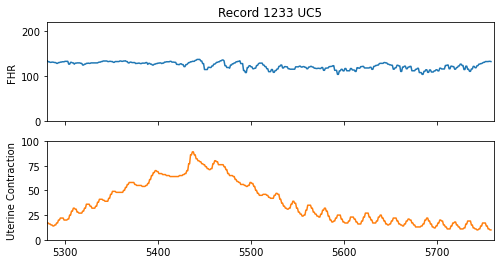

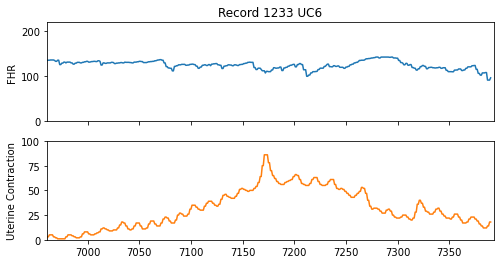

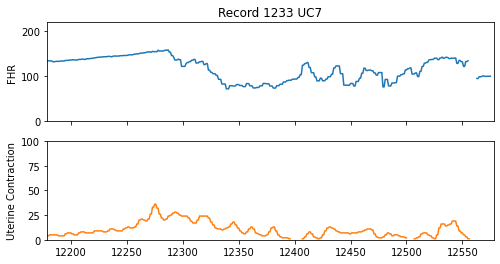

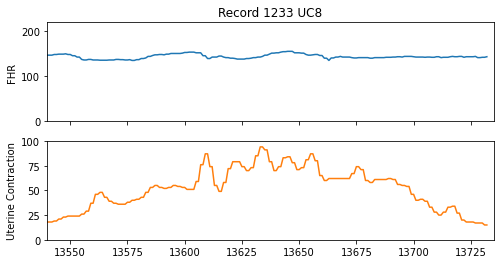

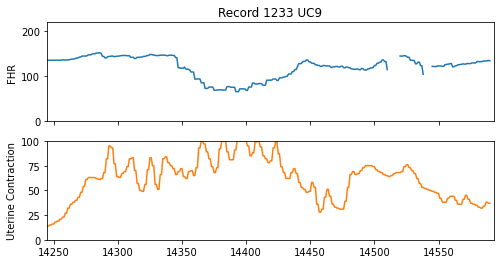

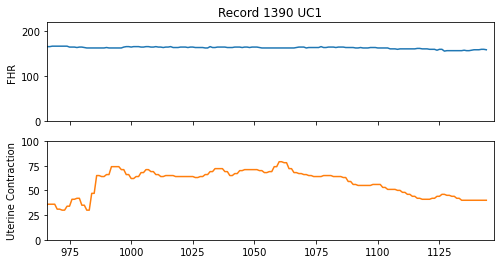

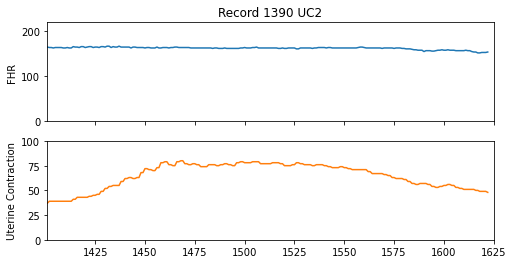

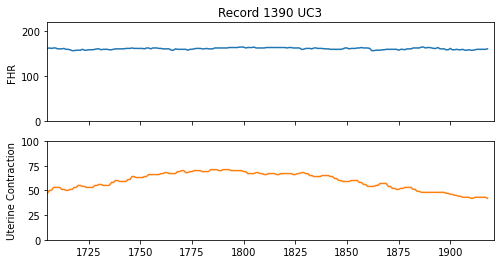

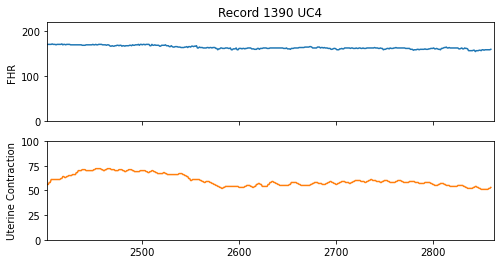

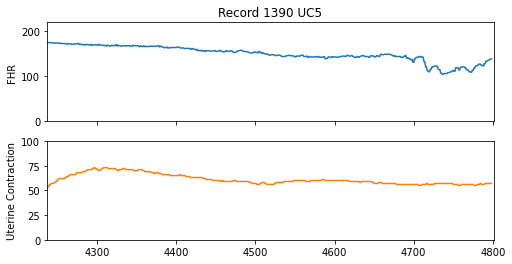

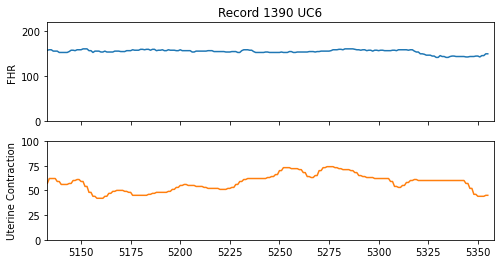

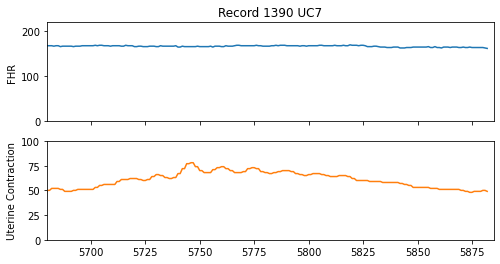

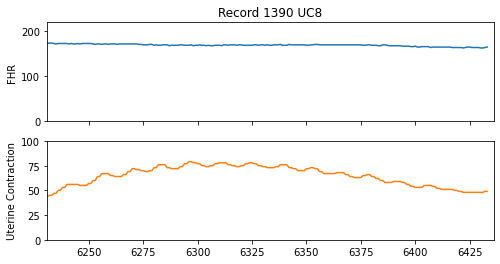

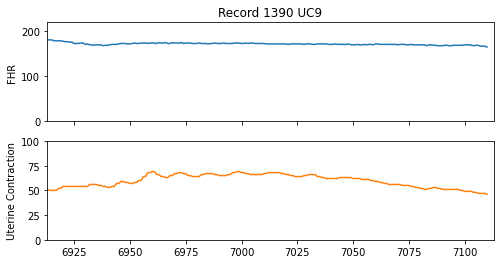

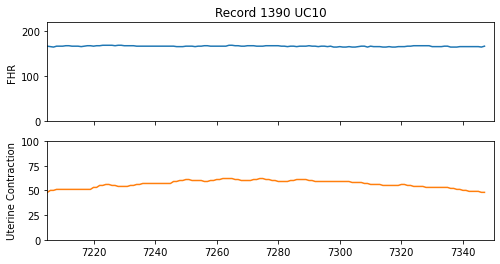

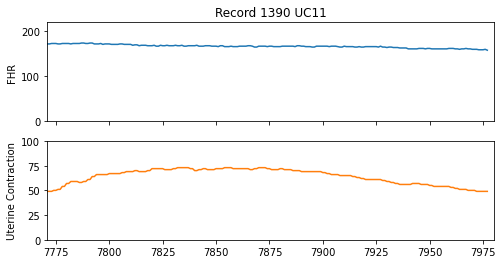

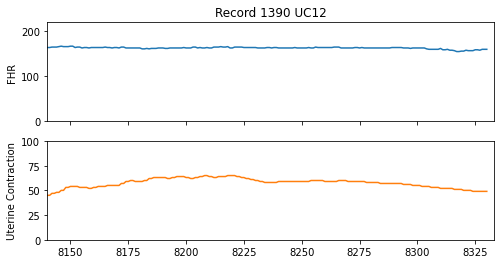

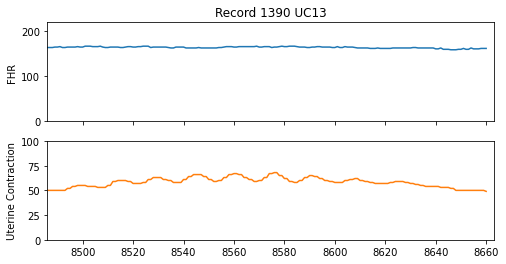

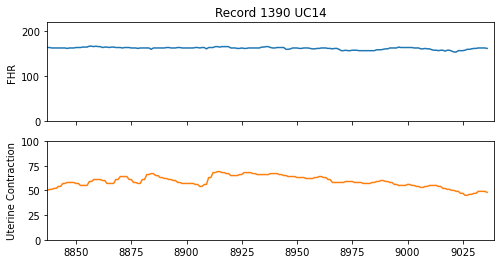

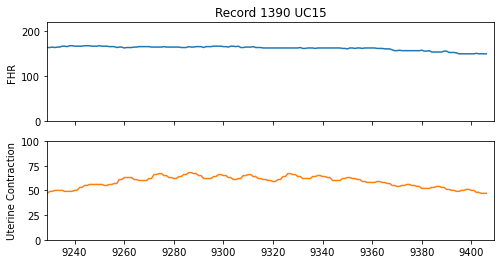

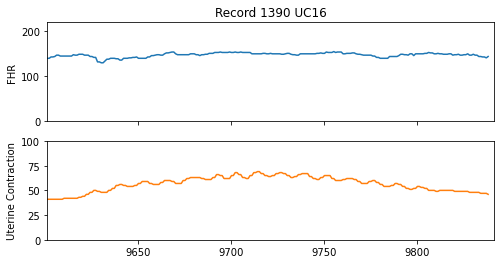

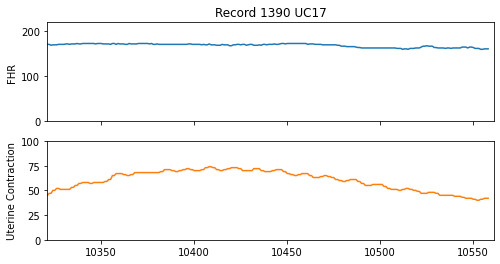

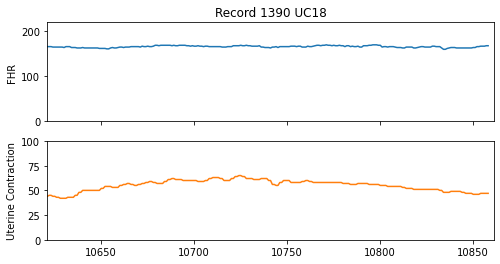

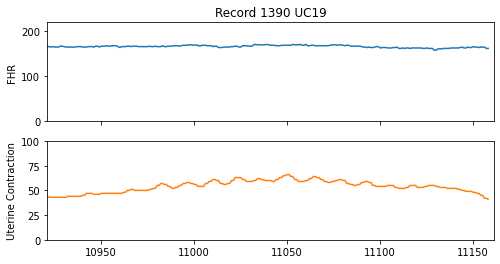

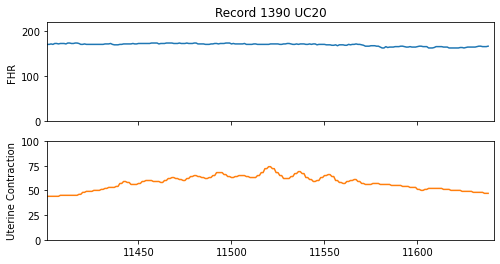

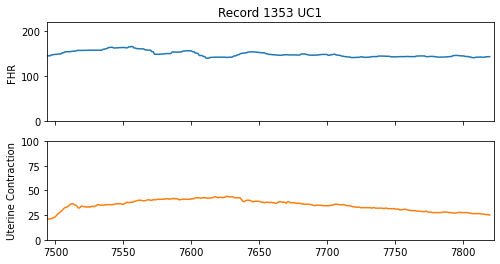

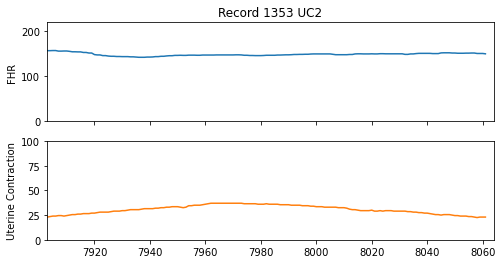

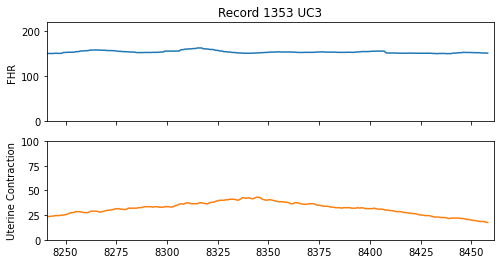

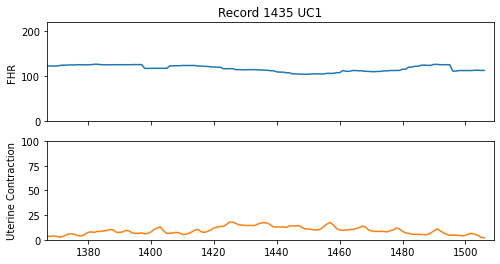

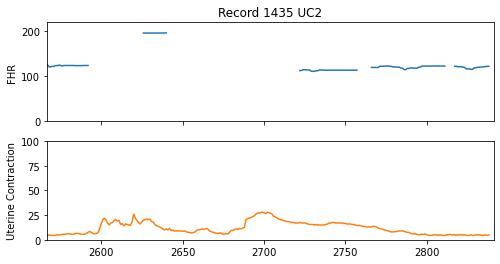

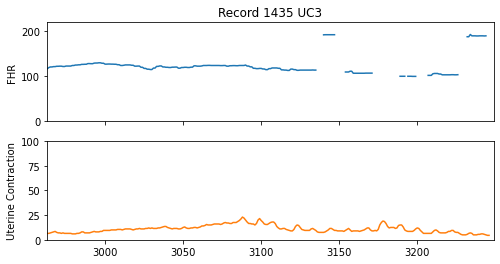

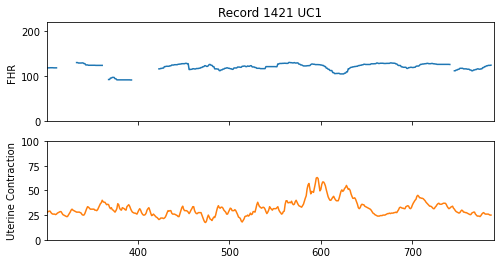

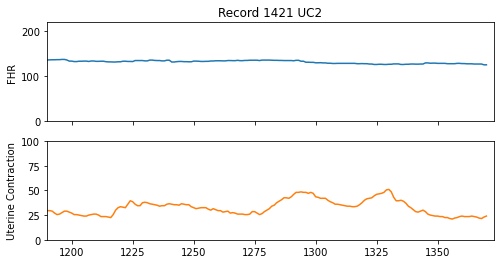

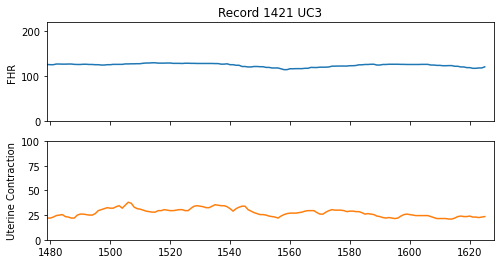

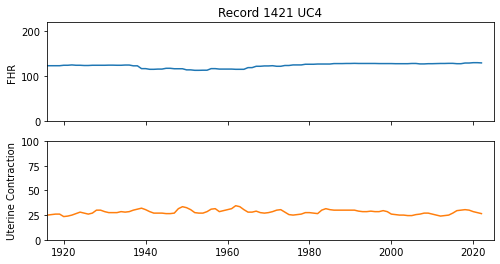

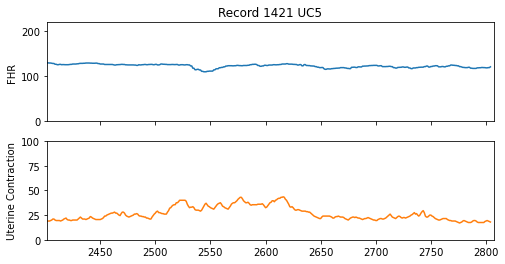

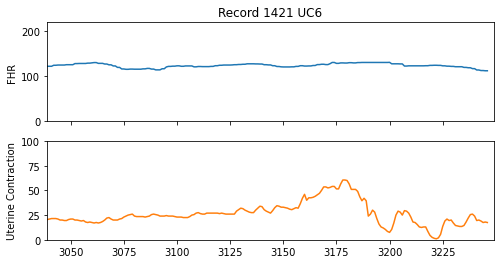

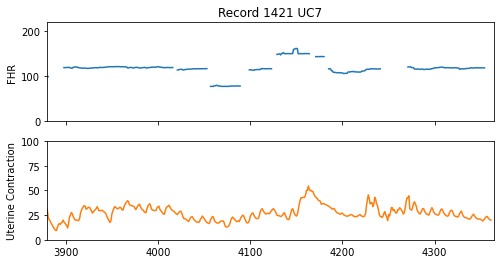

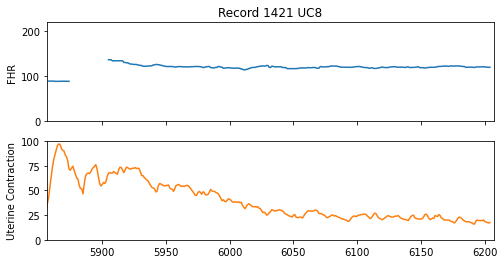

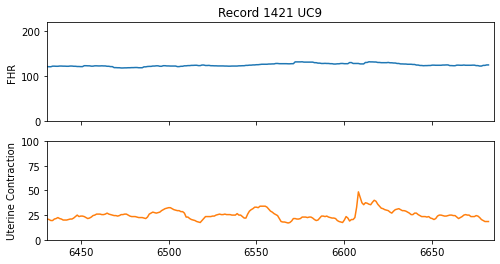

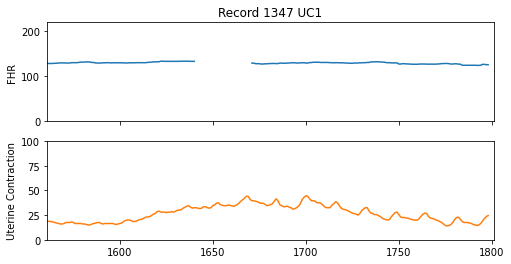

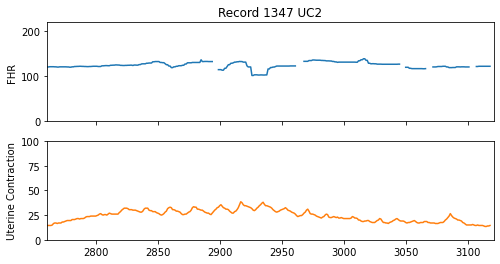

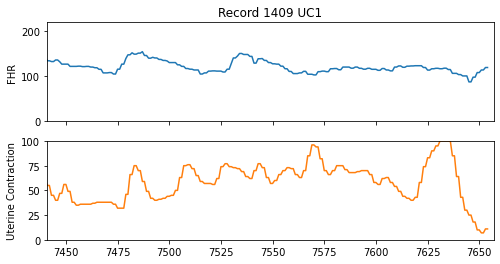

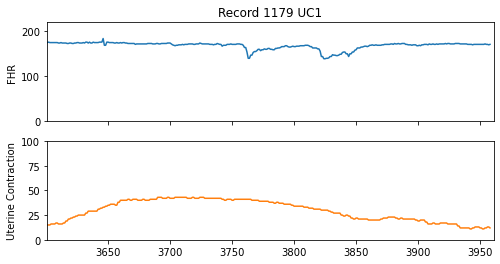

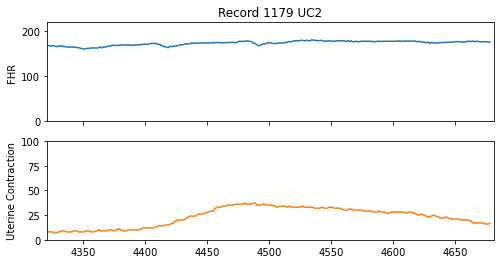

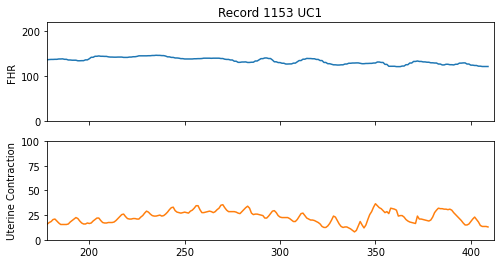

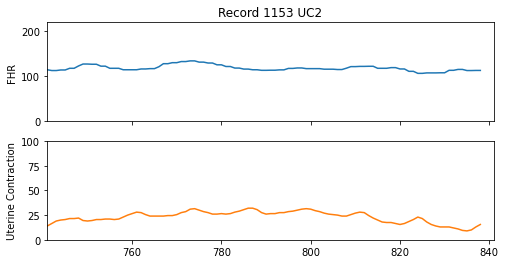

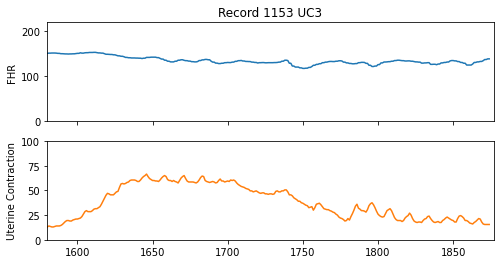

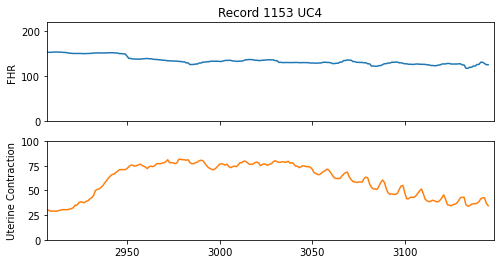

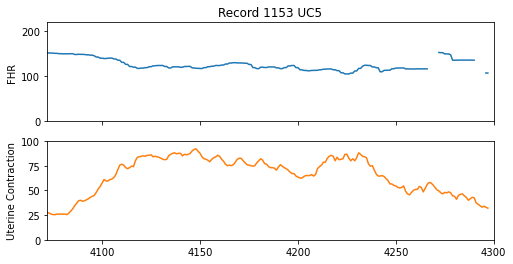

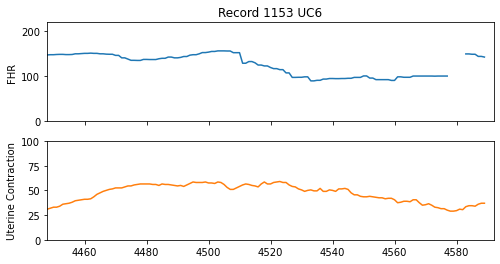

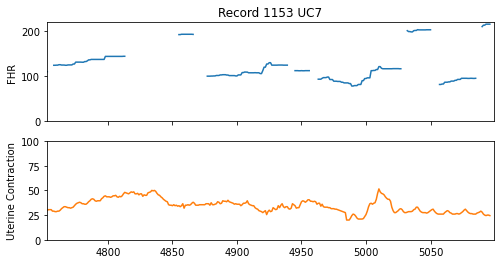

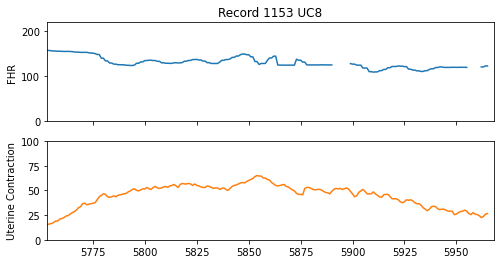

In [ ]:
# gets every single plot (just prints - need to figure out how to save)

error_list = [] # no errors
for i in record_numbers:
    rec = Record(str(i))
    uc_num = len(rec.ann['UC'])
    try: 
        for i in range(uc_num): 
            rec.plotUC(i)
    except:
        error_list.append(i)

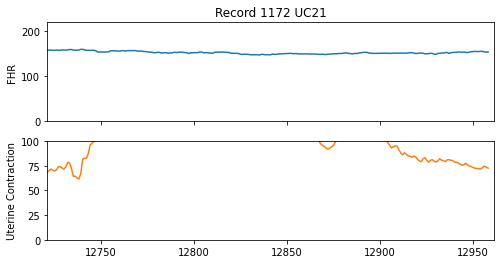

In [11]:
# UCs over 100 (1172 UC21)

rec = Record('1172')
rec.plotUC(21)

In [20]:
rec._signalDf['UC'].max() # can we show above 100?? current y-limit at 100

127.0

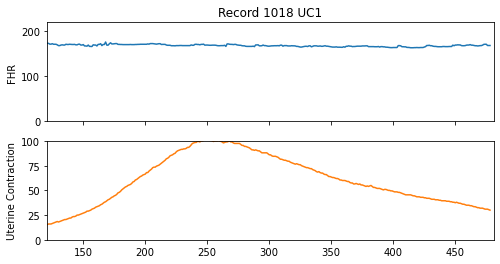

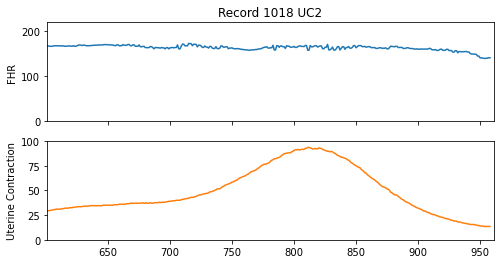

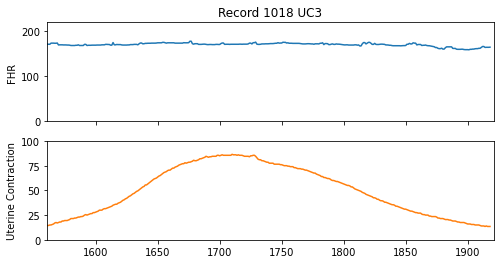

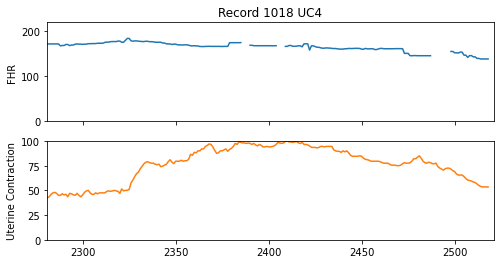

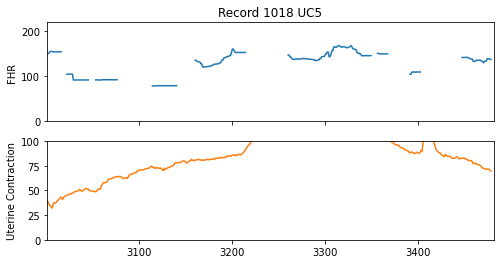

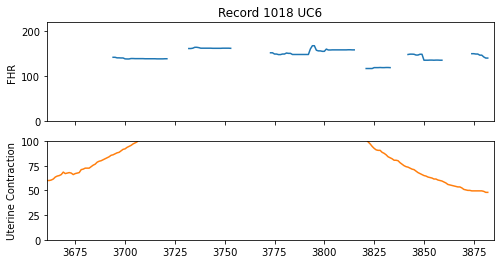

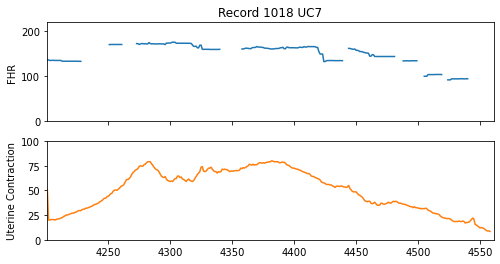

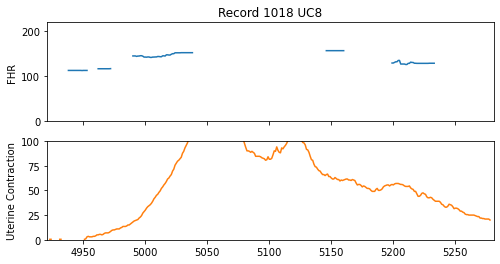

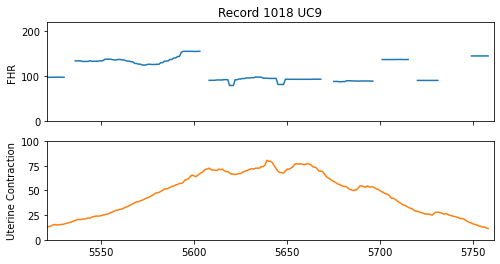

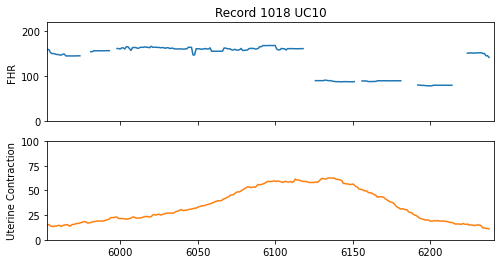

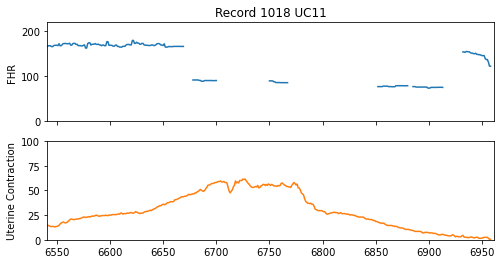

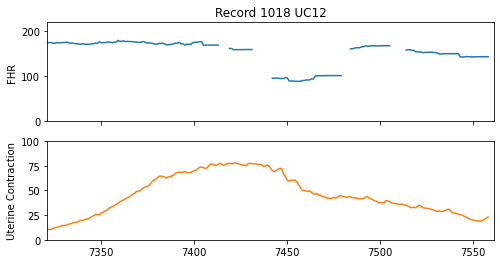

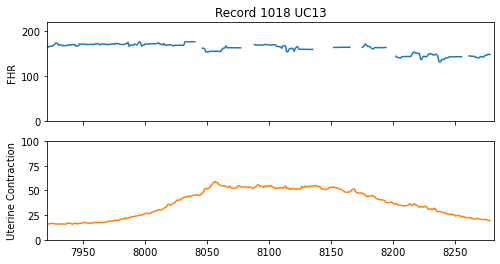

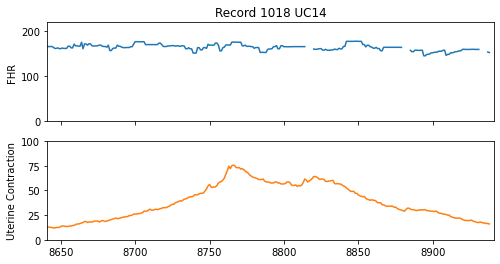

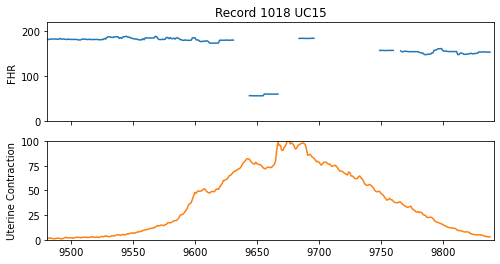

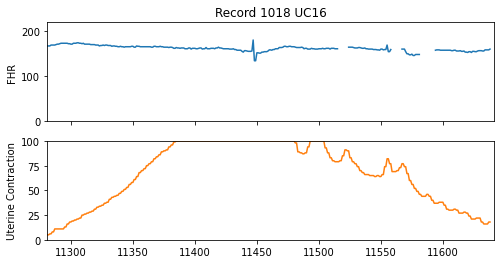

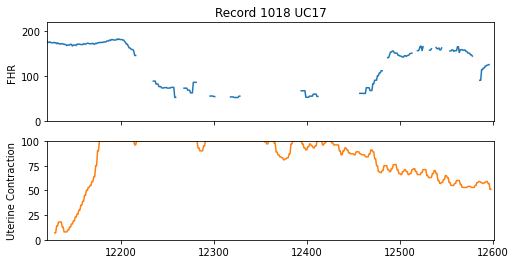

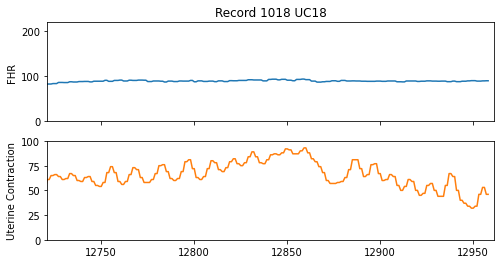

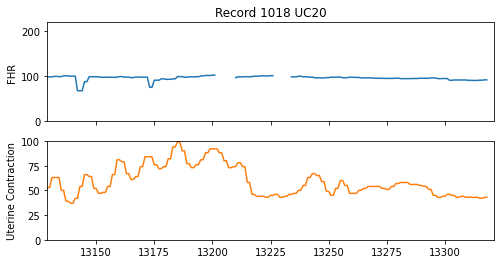

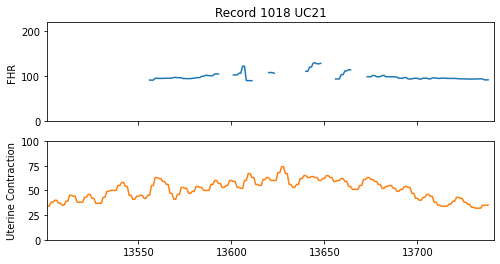

In [12]:
# missing data - 15 consecutive seconds of data loss for UC or FHR (1018 UC21)
rec = Record('1018')

for i in range(len(list(rec.ann['UC']))):
    rec.plotUC(i)

In [17]:
def findMissing(record):
    rec = Record(str(record))

    NA_list = []

    # gets all null index values within contraction times
    for i in range(len(rec.ann['UC'])):

        annotation_start = list(rec.ann['UC'].items())[i][1][0]
        annotation_end = list(rec.ann['UC'].items())[i][1][1]

        rec_df = rec._signalDf['FHR'][annotation_start:annotation_end]
        NA_list.append(list(rec_df[rec_df.isna()].index))

    import more_itertools as mit

    # finds consecutive index of null values
    null_list = []
    for i in range(len(NA_list)): 

        temp_list = NA_list[i]
        null_groups = [list(group) for group in mit.consecutive_groups(temp_list)] #gets consecutive numbers
        null_list.append(null_groups)

    # searches for over 15 seconds of consecutive loss
    uc_list = []
    for i1 in range((len(null_list))):
        for i2 in range(len(null_list[i1])):
            if len(null_list[i1][i2]) > 60:
                new_val = i1+1 # contraction with missing data
                uc_list.append(new_val)
                
    return uc_list

In [19]:
findMissing(1001)

[13, 15, 18, 19, 20, 21, 22]

In [52]:
rec.ann['UC']

{'UC1': [422, 599],
 'UC2': [671, 959],
 'UC3': [1584, 1679],
 'UC4': [2268, 2399],
 'UC5': [3162, 3444],
 'UC6': [3580, 3763],
 'UC7': [4547, 4799],
 'UC8': [11399, 11999],
 'UC9': [12679, 13199]}

In [199]:
int_df = rec._signalDf.interpolate(method='linear')

In [200]:
rec._signalDf = int_df

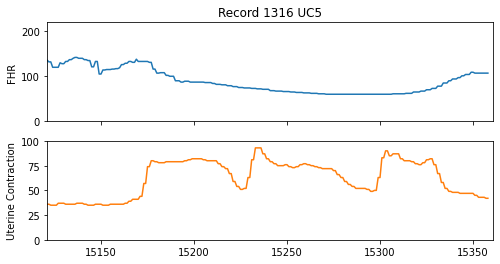

In [19]:
rec.plotUC(5)

In [181]:
rec.acc

{}

In [9]:
import numpy as np
from scipy.interpolate import interp1d
uc = rec1001._signalDf['UC']
fhr = rec1001._signalDf['FHR']
# uc.interpolate(method='spline', order=3)
# uc


In [10]:
uc.last_valid_index()

15599

In [137]:
#fhr.iloc[19017]

In [ ]:
uc.iloc[14938]

In [ ]:
rec1018._signalDf

In [ ]:

rec1018._signalDf['UC'] = pd.Series(np.interp(np.flatnonzero(t), np.flatnonzero(~t), uc[~t]))

In [ ]:
rec1018._signalDf

In [ ]:
rec1001.plotUC(2)

In [ ]:
rec1018.clearImages()

In [ ]:
rec1018.saveImages()

In [ ]:
record_nums = map(lambda x: x[-8:-4], os.listdir("../../data/annotations/csv"))
img_dirs = list(map(lambda x: x[-4:], glob.glob(f'../../data/images/*', recursive=False)))

In [ ]:
for rec in record_nums:
    if rec in img_dirs:
        record = Record(rec)
        record.clearImages()
        record.saveImages()
        del record